In [1]:
""" Created on July 29, 2022 // @author: Sarah Shi and Henry Towbin"""

import numpy as np
import pandas as pd 
import scipy.signal as signal
from peakdetect import peakdetect

import os
import glob 
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import rc, cm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 18})
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def Load_SampleCSV(paths, wn_high, wn_low): 

    """The Load_SampleCSV function takes the inputs of the path to a directory with all sample CSVs, wavenumber high, wavenumber low values. The function outputs a dictionary of each sample's associated wavenumbers and absorbances."""

    dfs = []
    files = []

    for path in paths:
        head_tail = os.path.split(path)
        file = head_tail[1][0:-4]

        df = pd.read_csv(path, names= ['Wavenumber', 'Absorbance'])
        df.set_index('Wavenumber', inplace = True)
        spec = df.loc[wn_low:wn_high]
        dfs.append(spec)
        files.append(file)

    df_zipobj = zip(files, dfs)
    dfs_dict = dict(df_zipobj)

    return files, dfs_dict


def PeakID(ref_spec, wn_high, wn_low, peak_heigh_min_delta, peak_search_width, savgol_filter_width, smoothing_wn_width = None, remove_baseline = False, plotting = False, filename = None):

    """Identifies peaks based on the peakdetect package which identifies local maxima and minima in noisy signals.
    Based on: https://github.com/avhn/peakdetect"""

    spec = ref_spec[wn_low:wn_high].copy() # dataframe indexed by wavenumber
    spec_filt = pd.DataFrame(columns = ['Wavenumber', 'Absorbance']) 
    baseline = 0

    spec_filter = signal.medfilt(spec.Absorbance, 3)

    if remove_baseline == True:
        baseline = signal.savgol_filter(spec_filter, savgol_filter_width, 3)
        spec_filter = spec_filter - baseline

    if smoothing_wn_width is not None:
        spec_filter = signal.savgol_filter(spec_filter, smoothing_wn_width, 3)

    spec_filt['Absorbance'] = spec_filter
    spec_filt.index = spec.index
    spec['Subtracted'] = spec['Absorbance'] - baseline

    pandt = peakdetect(spec_filt.Absorbance, spec_filt.index, lookahead = peak_search_width, delta = peak_heigh_min_delta)
    peaks = np.array(pandt[0])
    troughs = np.array(pandt[1])

    if plotting == True: 
        fig, ax = plt.subplots(1, 1, figsize = (8, 6))
        ax.plot(spec.index, spec['Subtracted'], linewidth = 1)
        ax.plot(spec_filt.index, spec_filt.Absorbance)
        ax.plot(peaks[:,0], peaks[:,1], 'ro')
        ax.plot(troughs[:,0], troughs[:,1], 'ko')
        ax.set_title(filename)
        ax.set_xlabel('Wavenumber')
        ax.set_ylabel('Absorbance')
        ax.invert_xaxis()

    # spec.to_csv(filename + '_spec.csv')
    # spec_filt.to_csv(filename + '_specfilt.csv')
    # pd.DataFrame(peaks).to_csv(filename + '_peaks.csv')
    # pd.DataFrame(troughs).to_csv(filename + '_troughs.csv')

    return peaks, troughs


def ThicknessCalc(n, positions):

    """Calculates thicknesses of glass wafers based on the refractive index of the glass and the positions of the peaks or troughs in the FTIR spectrum."""

    return 1/(2 * n * np.abs(np.diff(positions)))


def ThicknessProcessing(dfs_dict, n, wn_high, wn_low, savgol_filter_width, smoothing_wn_width = None, 
    peak_heigh_min_delta = 0.008, peak_search_width = 50, remove_baseline = False, plotting=False):

    """Calculates thickness of glass wafers based on the refractive index of the glass and the positions of the peaks or troughs in the FTIR spectrum. Thicknesses for each interference fringe, starting at both the peaks and troughs of the fringes are determined. These thicknesses are then averaged over the interval of interest."""

    ThickDF = pd.DataFrame(columns=['Peak_Thicknesses', 'Peak_Thickness_M', 'Peak_Thickness_STD', 'Peak_Loc', 'Peak_Diff', 'Trough_Thicknesses', 'Trough_Thickness_M', 'Trough_Thickness_STD', 'Trough_Loc', 'Trough_Diff','Thickness_M', 'Thickness_STD'])
    failures = []

    for filename, data in dfs_dict.items(): 
        try:
            peaks, troughs = PeakID(data, wn_high, wn_low,  filename=filename, plotting=plotting, savgol_filter_width=savgol_filter_width, smoothing_wn_width = smoothing_wn_width, remove_baseline = True, peak_heigh_min_delta = peak_heigh_min_delta, peak_search_width = peak_search_width)
            peaks_loc = peaks[:, 0].round(2)
            troughs_loc = troughs[:, 0].round(2)
            peaks_diff = np.diff(peaks[:, 0]).round(2)
            troughs_diff = np.diff(troughs[:, 0]).round(2)

            peaks_loc_filt = np.array([x for x in peaks_loc if abs(x - np.mean(peaks_loc)) < np.std(peaks_loc)])
            troughs_loc_filt = np.array([x for x in troughs_loc if abs(x - np.mean(troughs_loc)) < np.std(troughs_loc)])
            peaks_diff_filt = np.array([x for x in peaks_diff if abs(x - np.mean(peaks_diff)) < np.std(peaks_diff)])
            troughs_diff_filt = np.array([x for x in troughs_diff if abs(x - np.mean(troughs_diff)) < np.std(troughs_diff)])

            t_peaks = (ThicknessCalc(n, peaks[:,0]) * 1e4).round(2)
            mean_t_peaks = np.mean(t_peaks)
            std_t_peaks = np.std(t_peaks)
            t_peaks_filt = np.array([x for x in t_peaks if abs(x - np.mean(t_peaks)) < np.std(t_peaks)])
            mean_t_peaks_filt = np.mean(t_peaks_filt).round(2)
            std_t_peaks_filt = np.std(t_peaks_filt).round(2)

            t_troughs = (ThicknessCalc(n, troughs[:,0]) * 1e4).round(2)
            mean_t_troughs = np.mean(t_troughs)
            std_t_troughs = np.std(t_troughs)
            t_troughs_filt = [x for x in t_troughs if abs(x - np.mean(t_troughs)) < np.std(t_troughs)]
            mean_t_troughs_filt = np.mean(t_troughs_filt).round(2)
            std_t_troughs_filt = np.std(t_troughs_filt).round(2)

            mean_t = np.mean(np.concatenate([t_peaks_filt, t_troughs_filt])).round(2)
            std_t = np.std(np.concatenate([t_peaks_filt, t_troughs_filt])).round(2)

            ThickDF.loc[f"{filename}"] = pd.Series({'Peak_Thicknesses': t_peaks_filt, 'Peak_Thickness_M': mean_t_peaks_filt, 'Peak_Thickness_STD': std_t_peaks_filt, 'Peak_Loc': peaks_loc_filt, 'Peak_Diff': peaks_diff_filt, 'Trough_Thicknesses': t_troughs_filt, 'Trough_Thickness_M': mean_t_troughs_filt, 'Trough_Thickness_STD': std_t_troughs_filt, 'Trough_Loc': troughs_loc_filt, 'Trough_Diff': troughs_diff_filt, 'Thickness_M': mean_t, 'Thickness_STD': std_t})

        except Exception as e:
            print(f"Error: {e}")
            print(e)
            failures.append(filename)
            ThickDF.loc[filename] = pd.Series({'V1':np.nan,'V2':np.nan,'Thickness':np.nan})

    return ThickDF


def ReflectanceIndex(XFo):
    
    """Calculates reflectance index for given forsterite composition. Values based on those from Deer, Howie, and Zussman, 3rd Edition. Input forsterite in mole fraction."""

    n_alpha = 1.827 - 0.192*XFo
    n_beta = 1.869 - 0.218*XFo
    n_gamma = 1.879 - 0.209*XFo
    n = (n_alpha+n_beta+n_gamma) / 3

    return n

/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sarahc

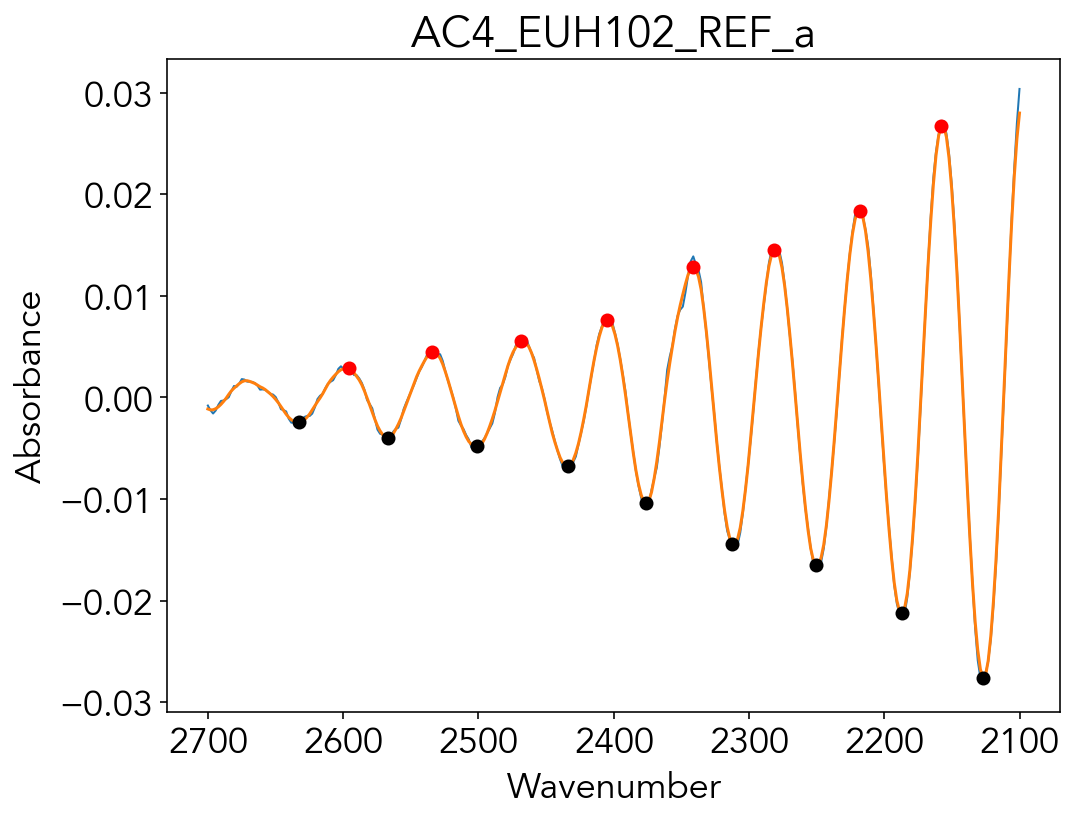

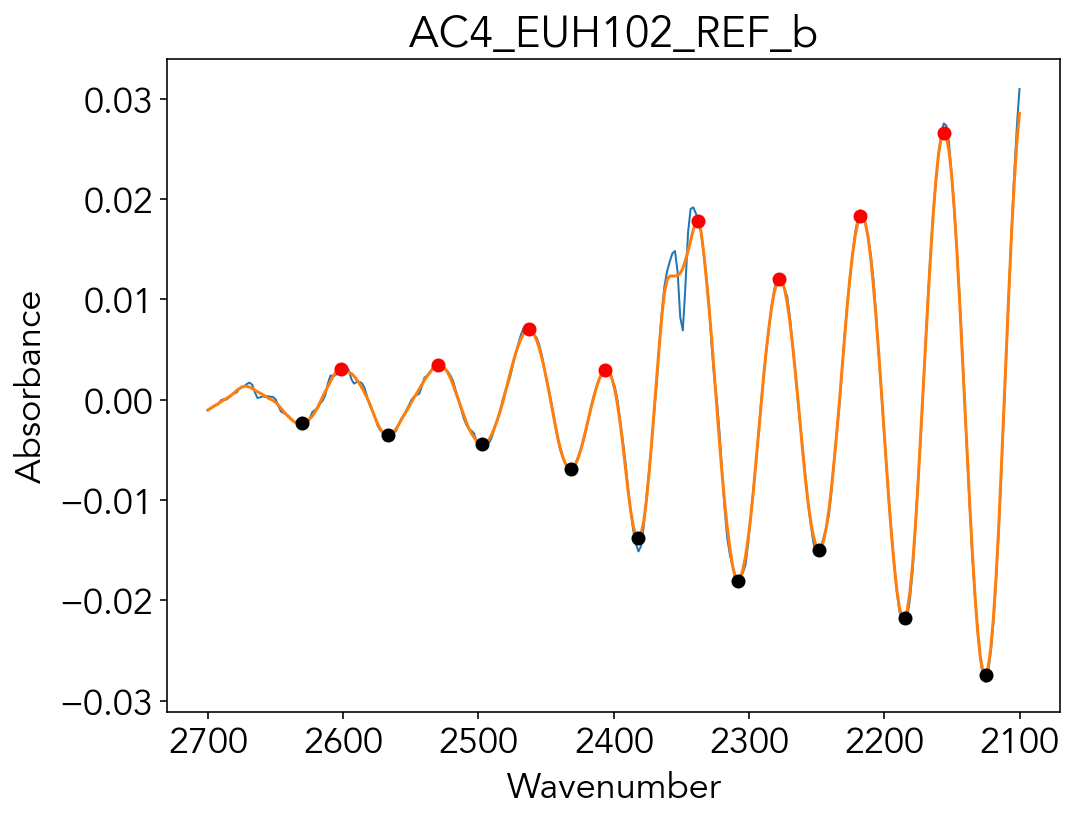

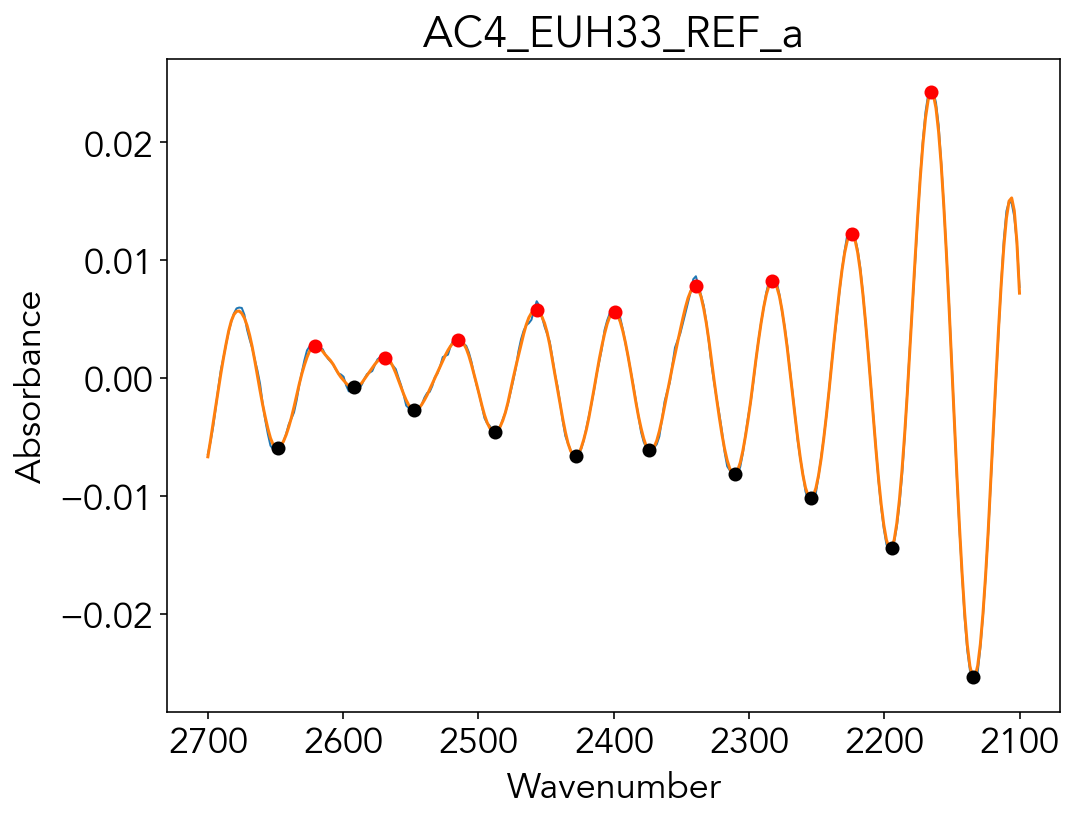

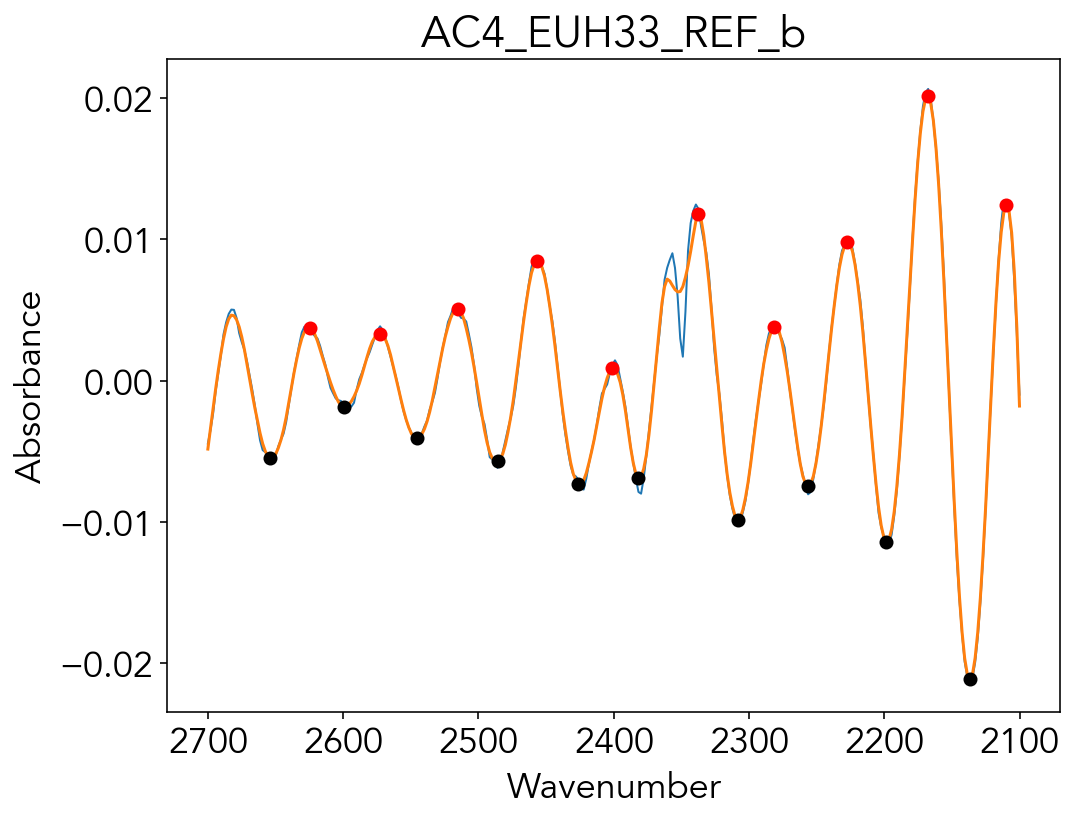

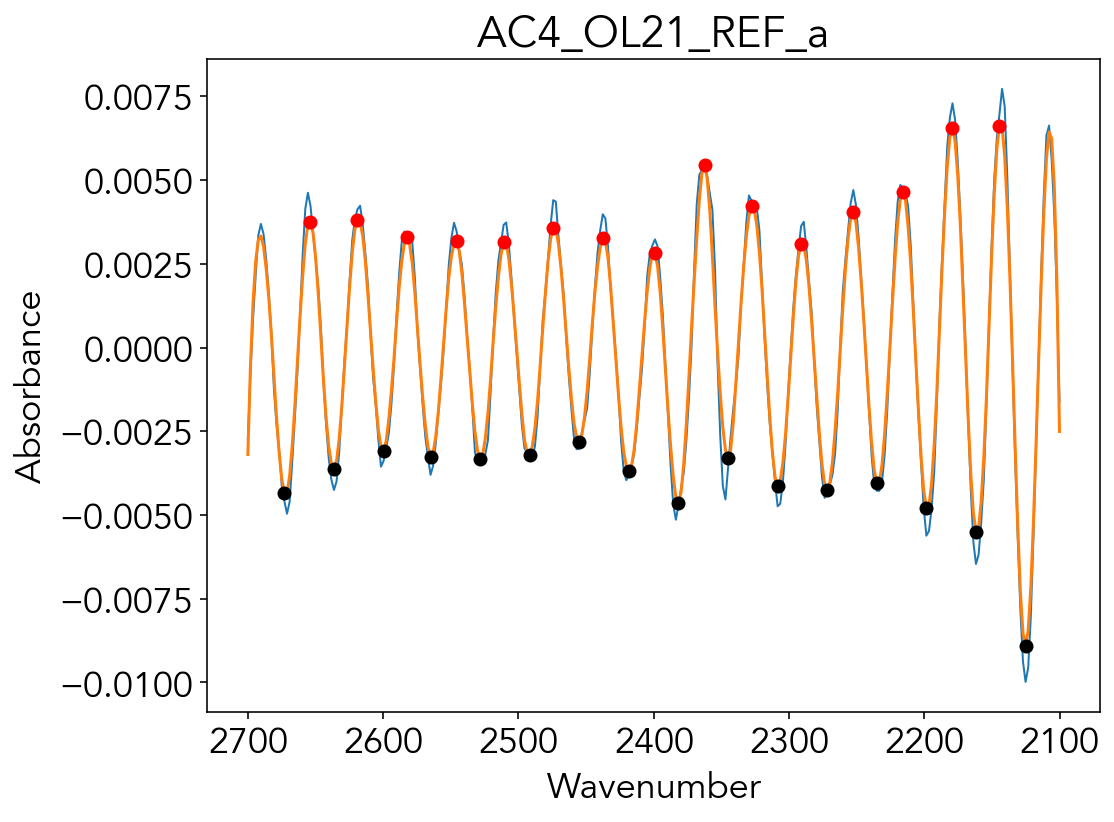

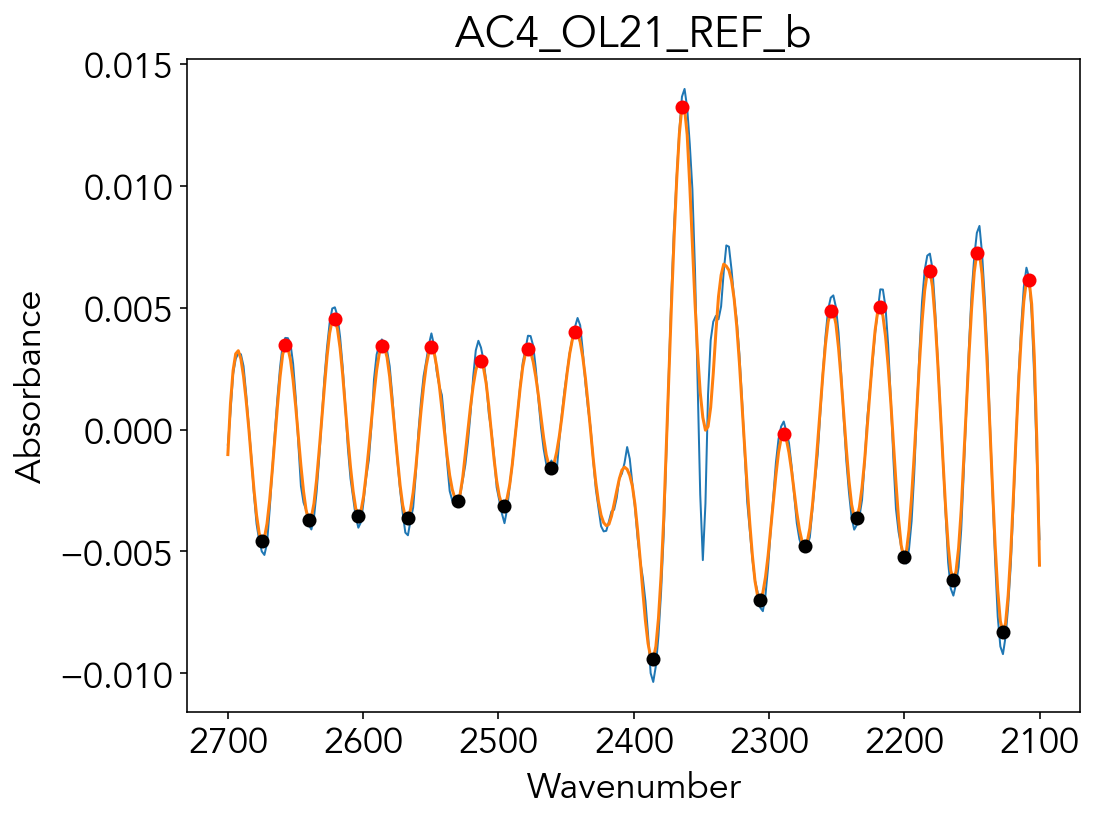

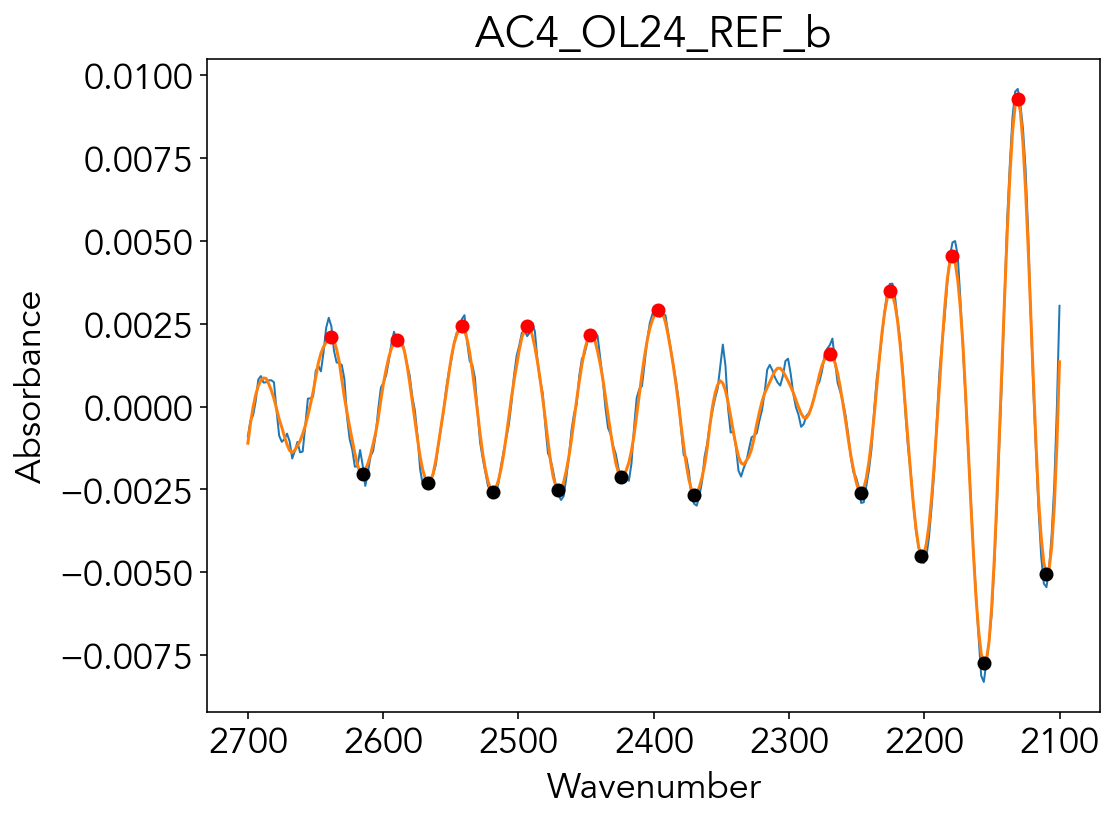

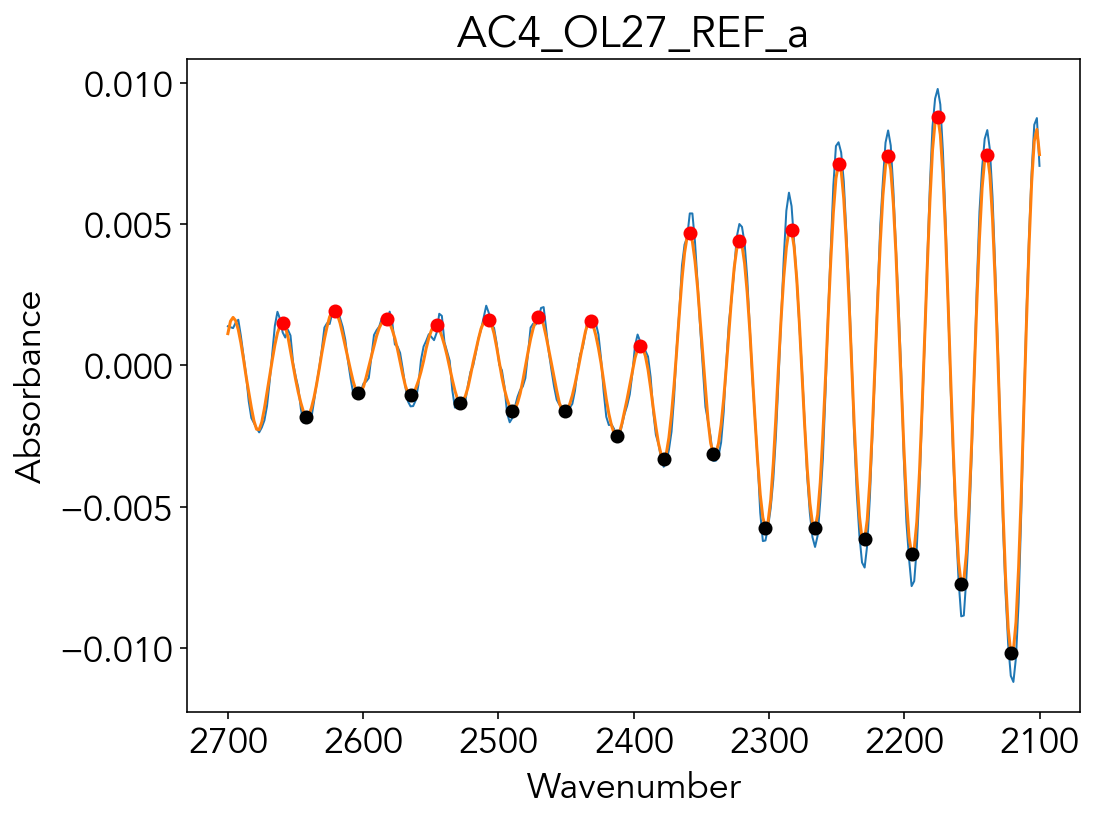

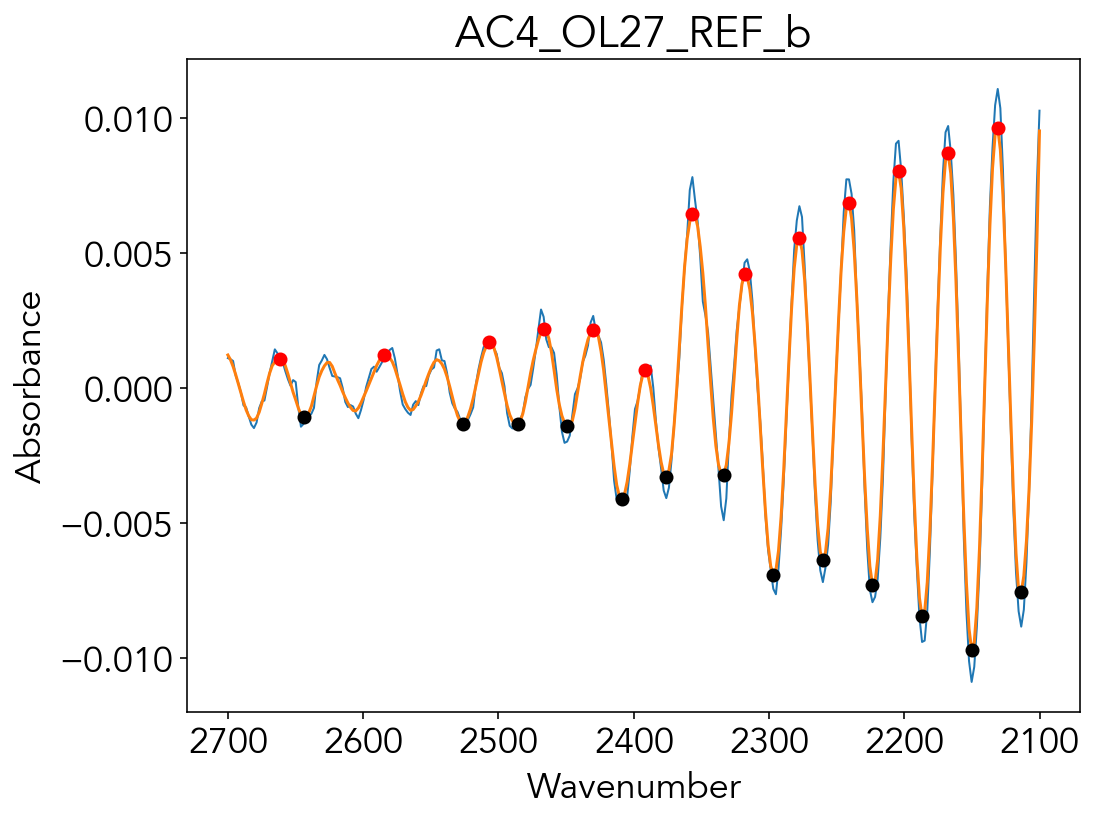

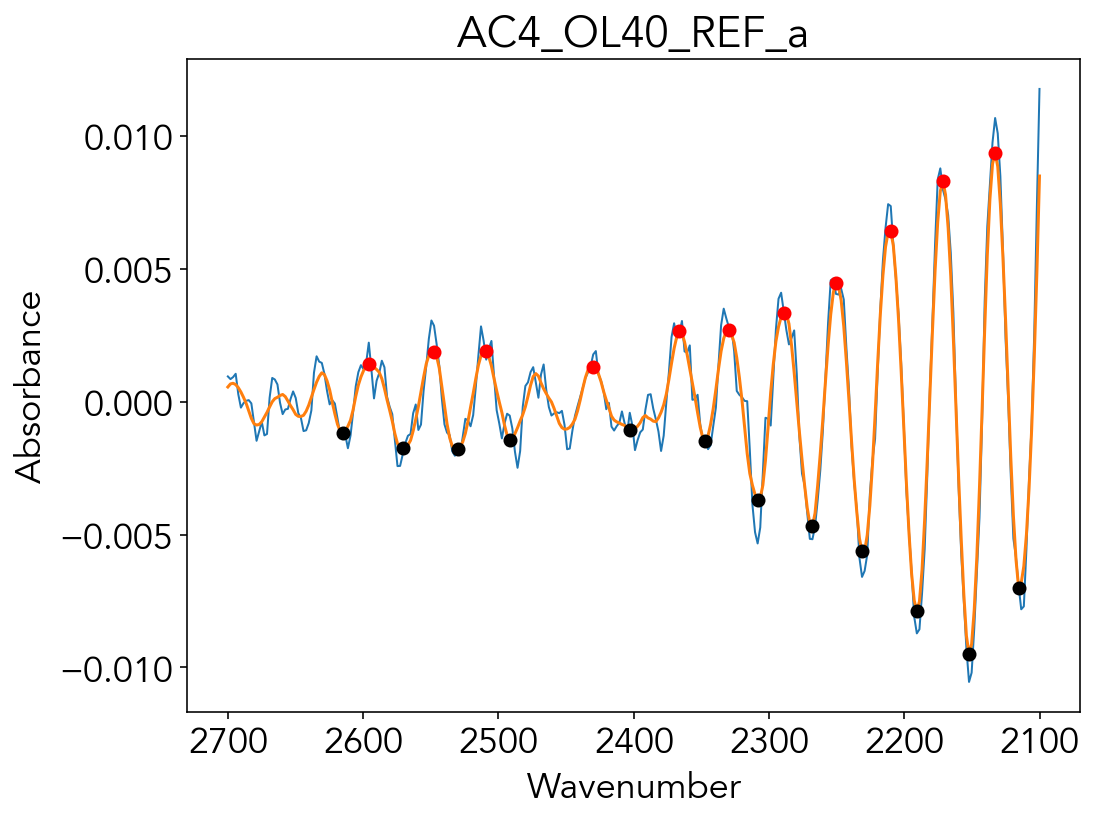

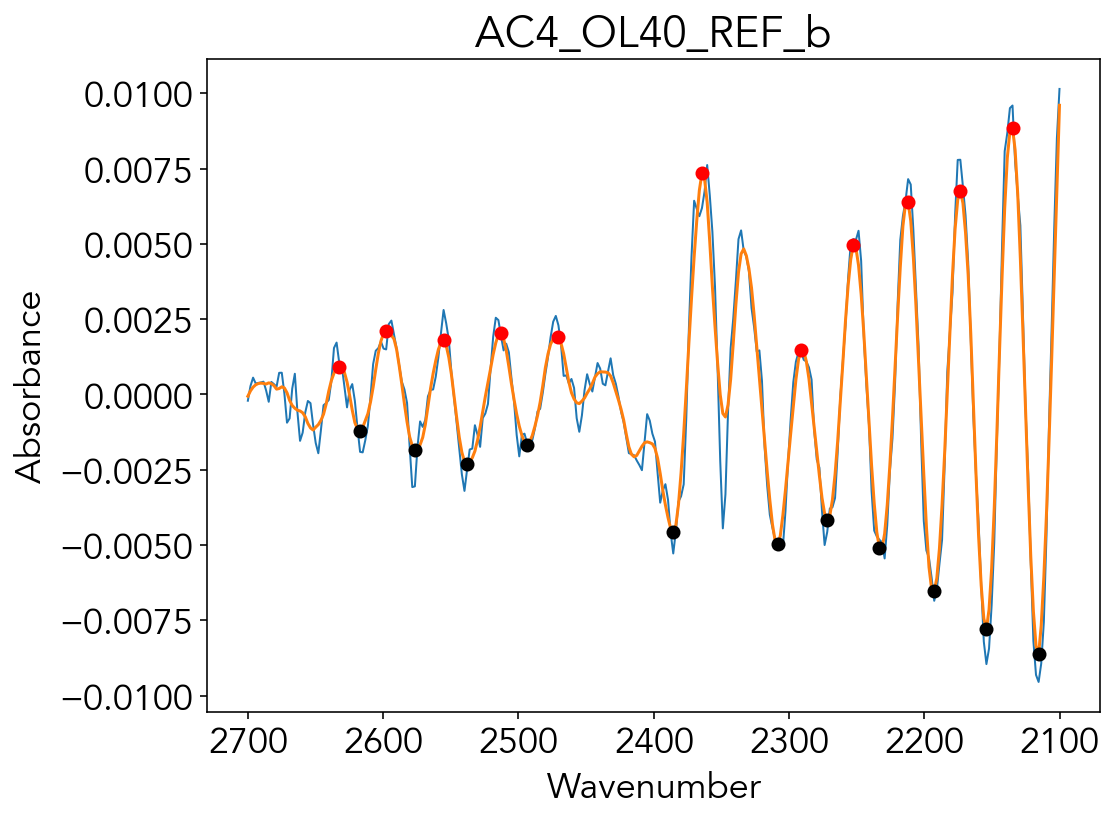

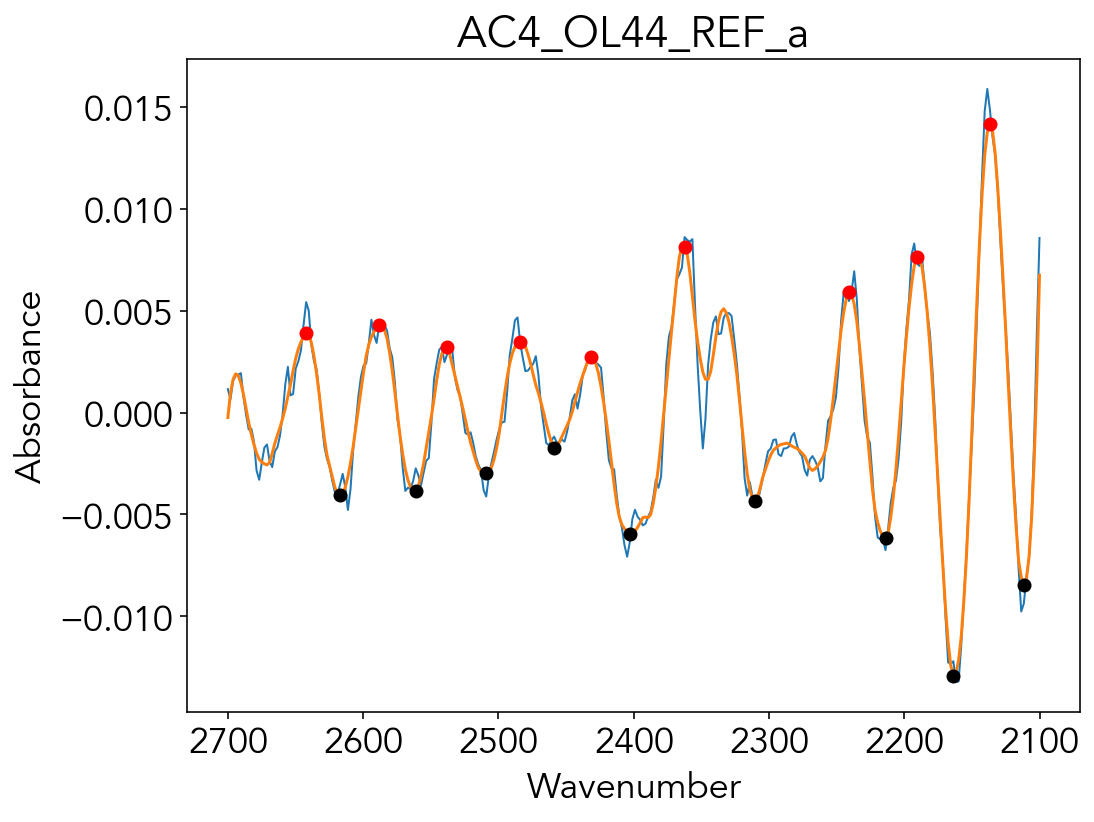

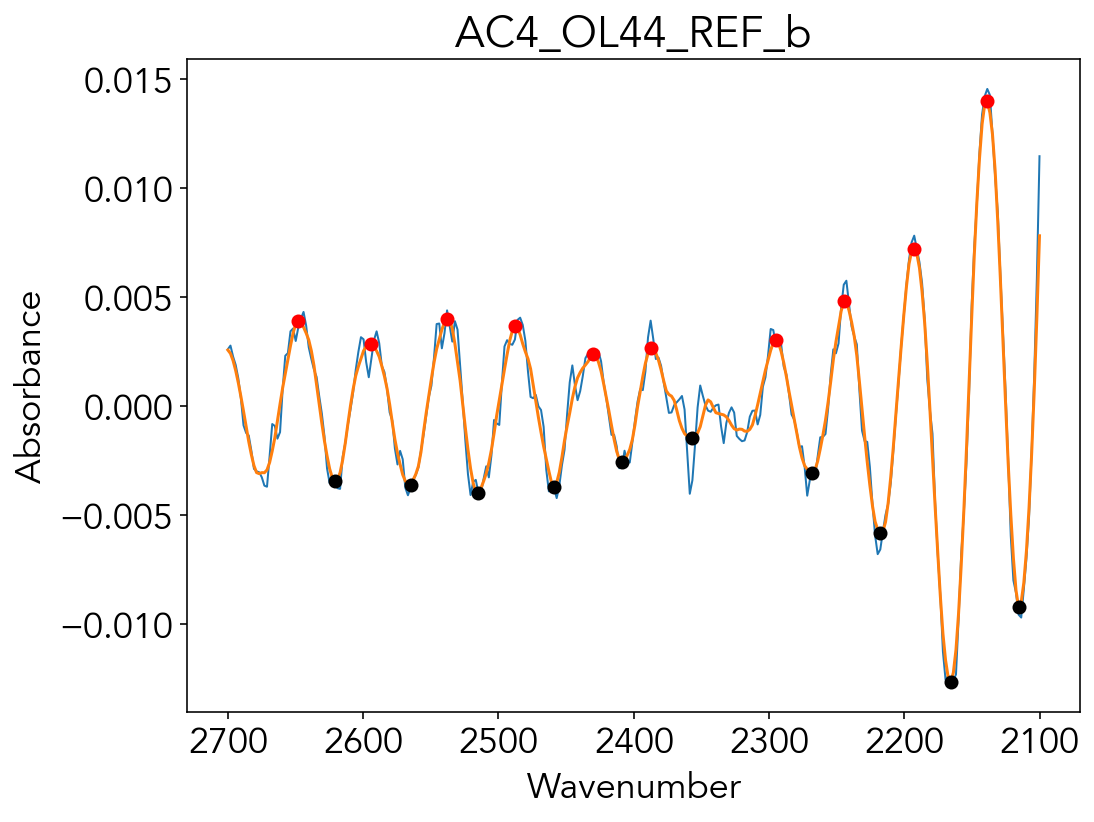

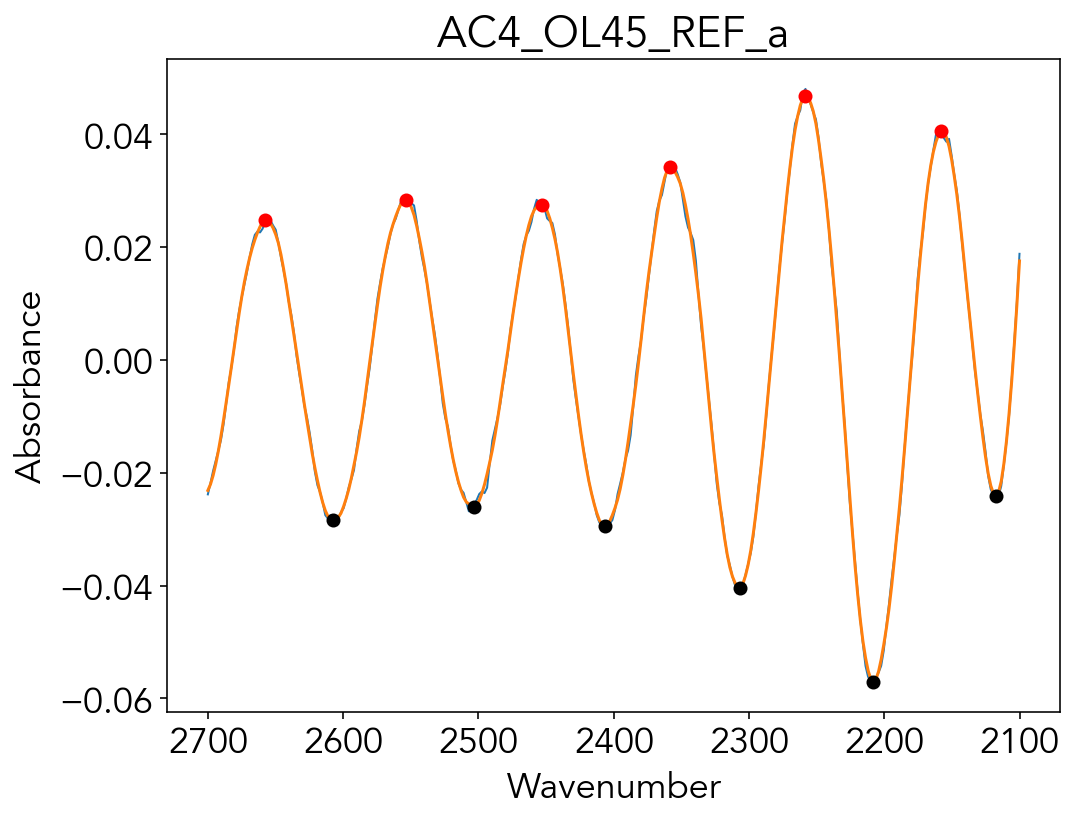

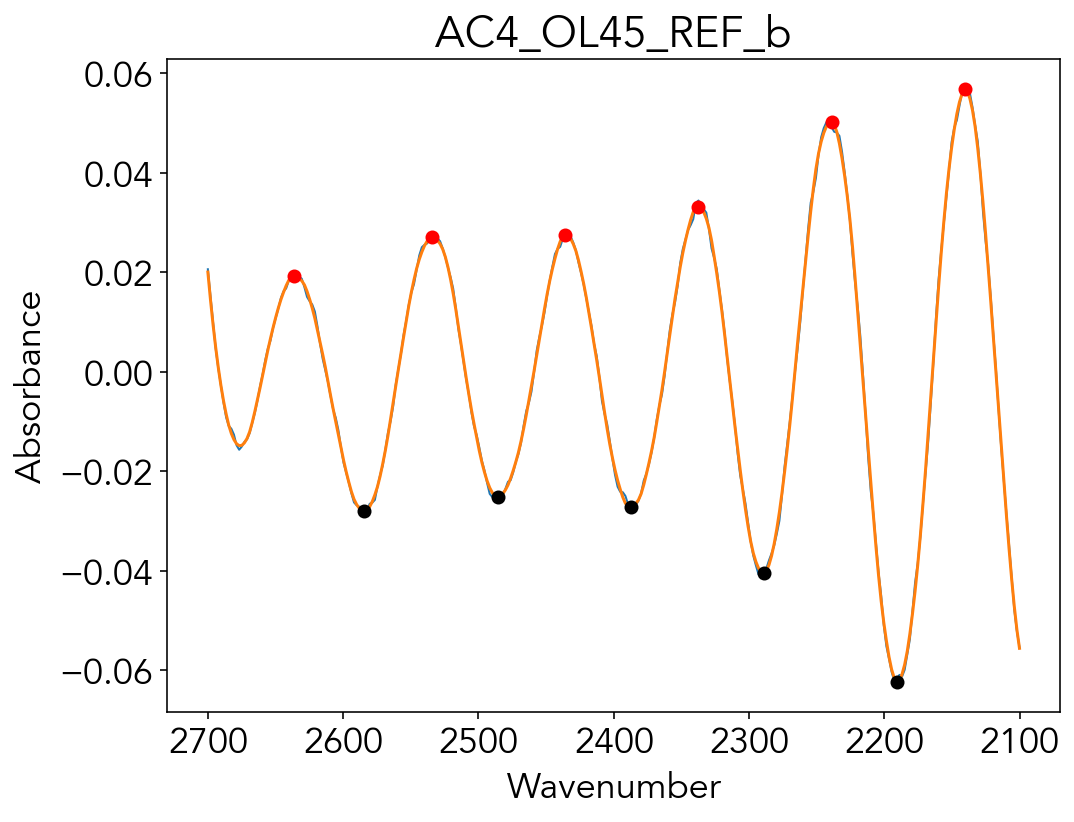

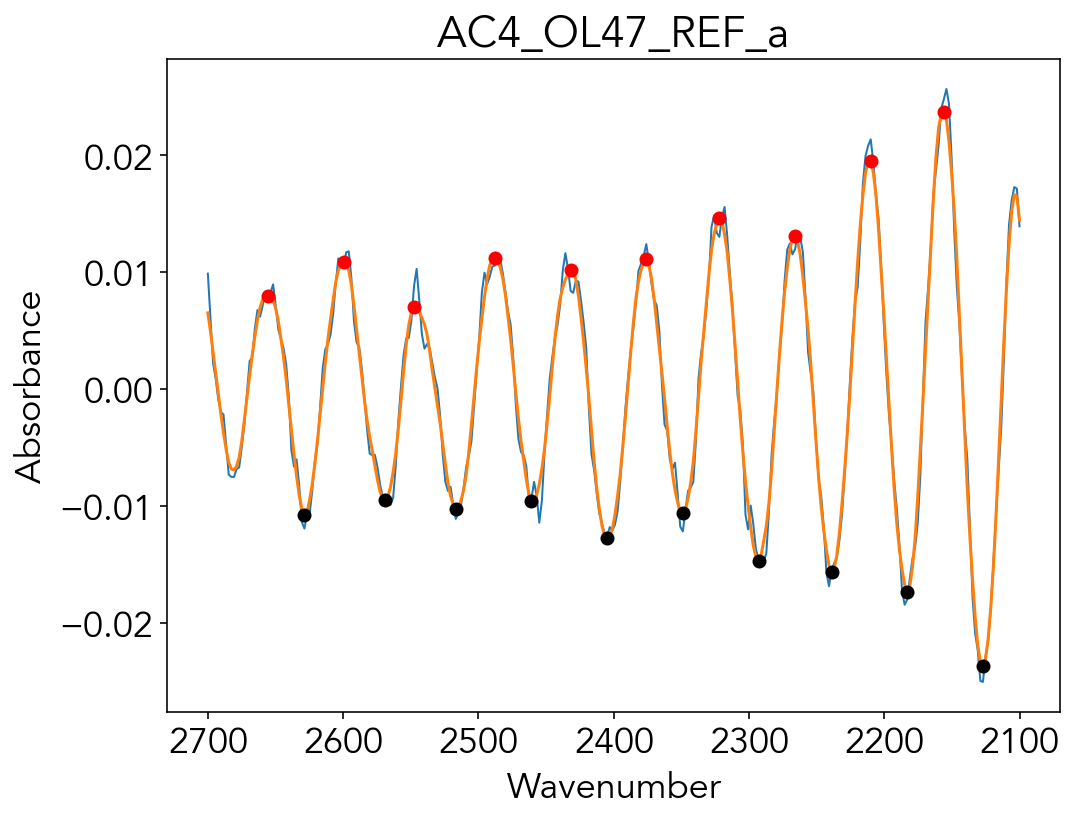

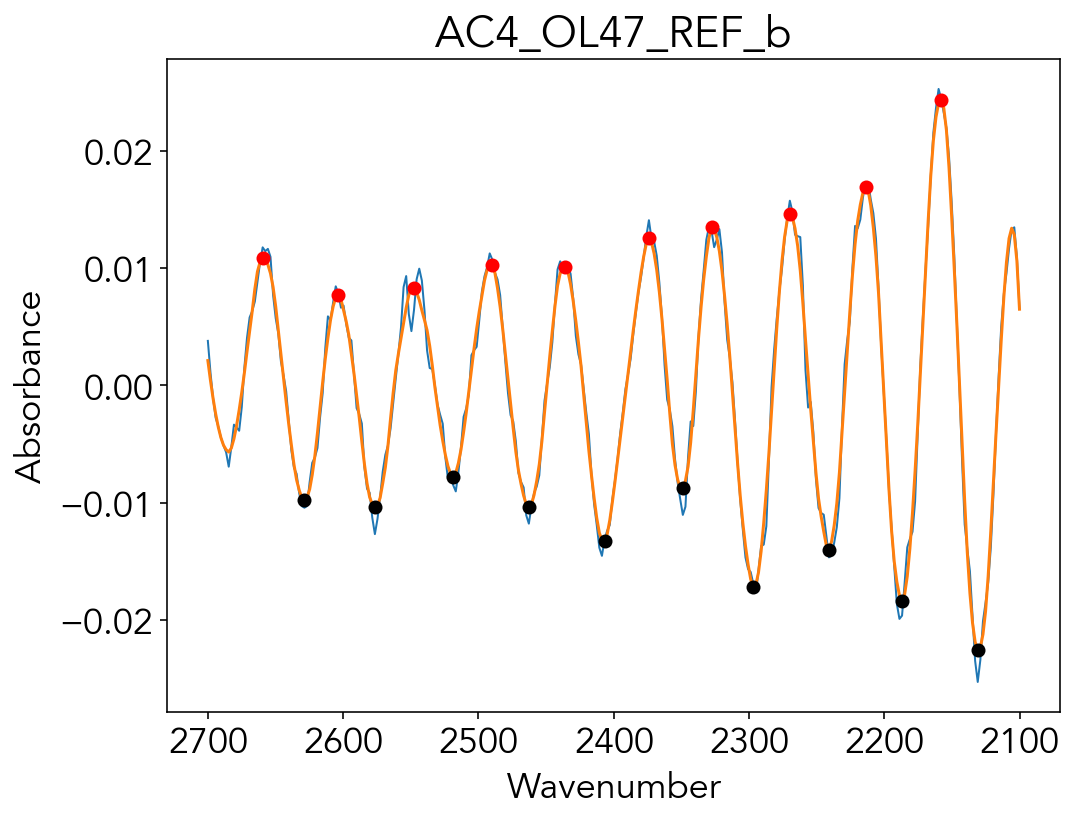

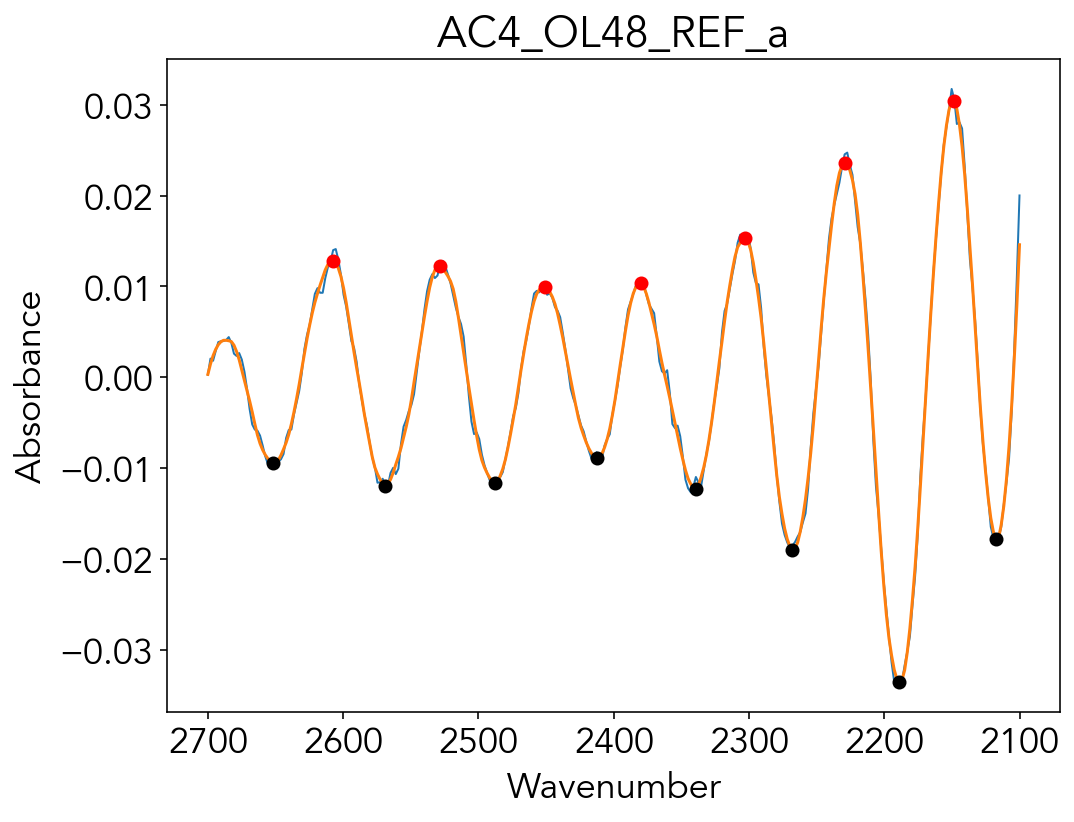

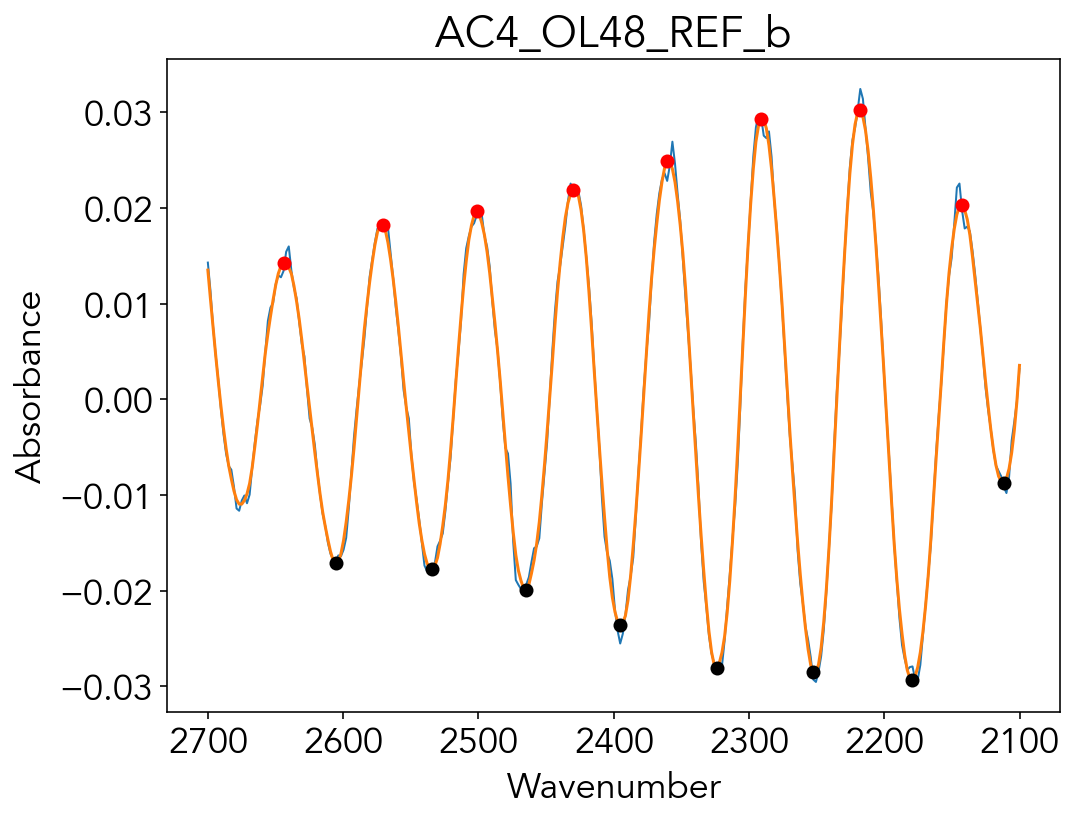

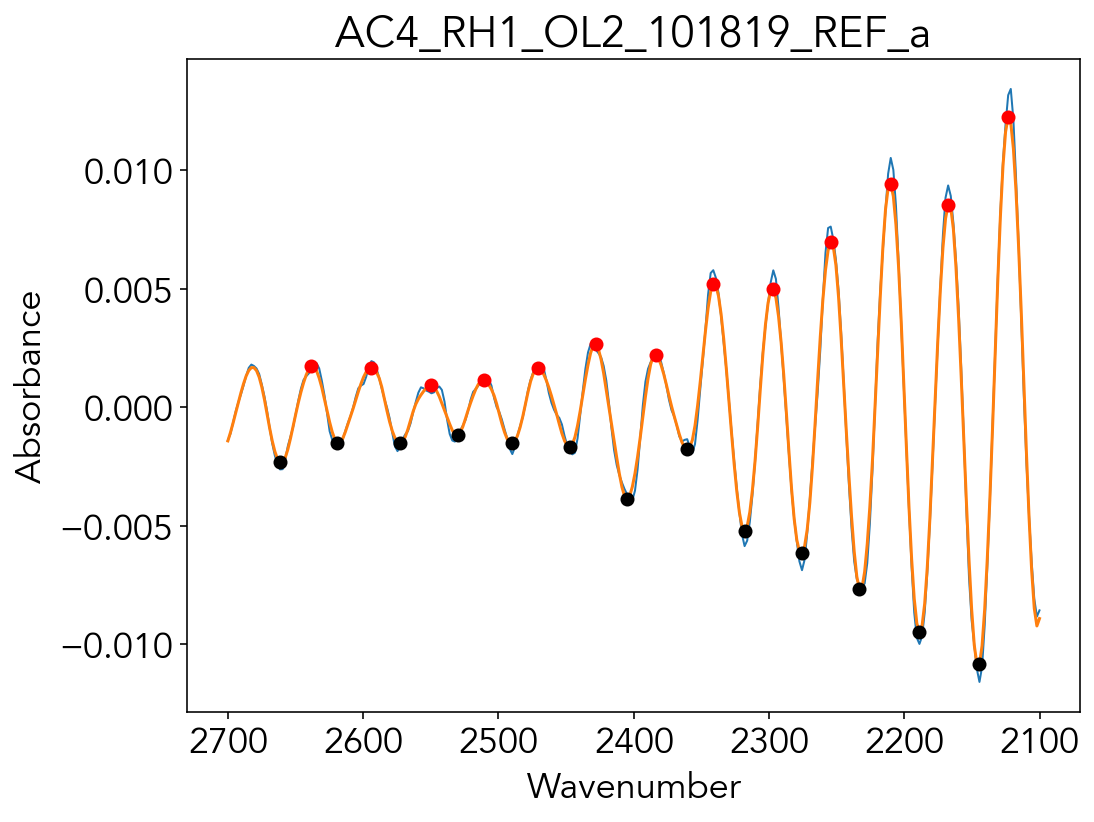

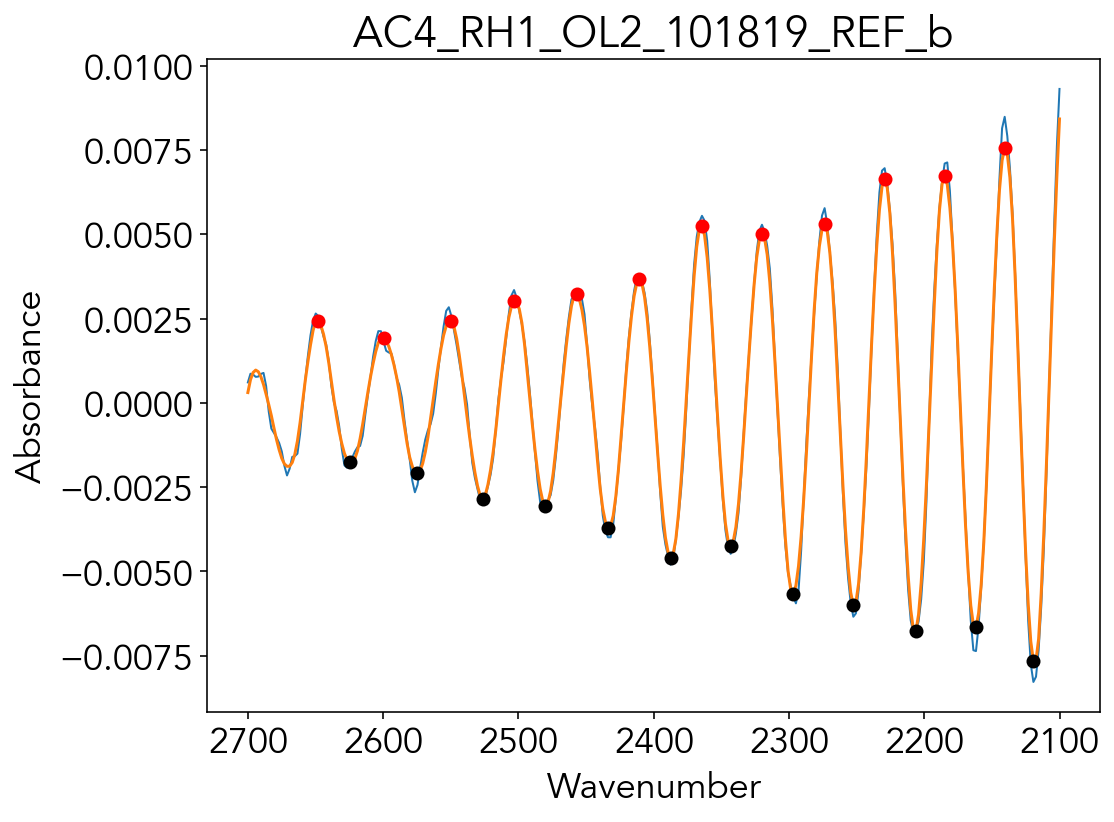

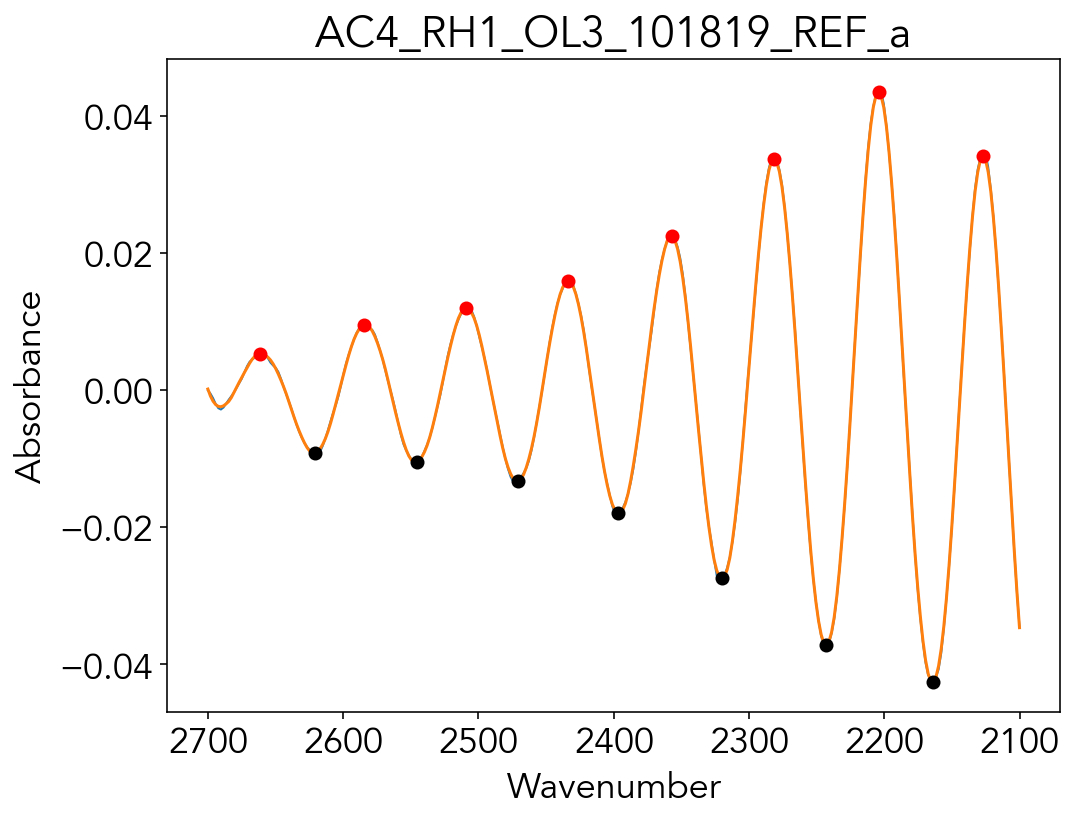

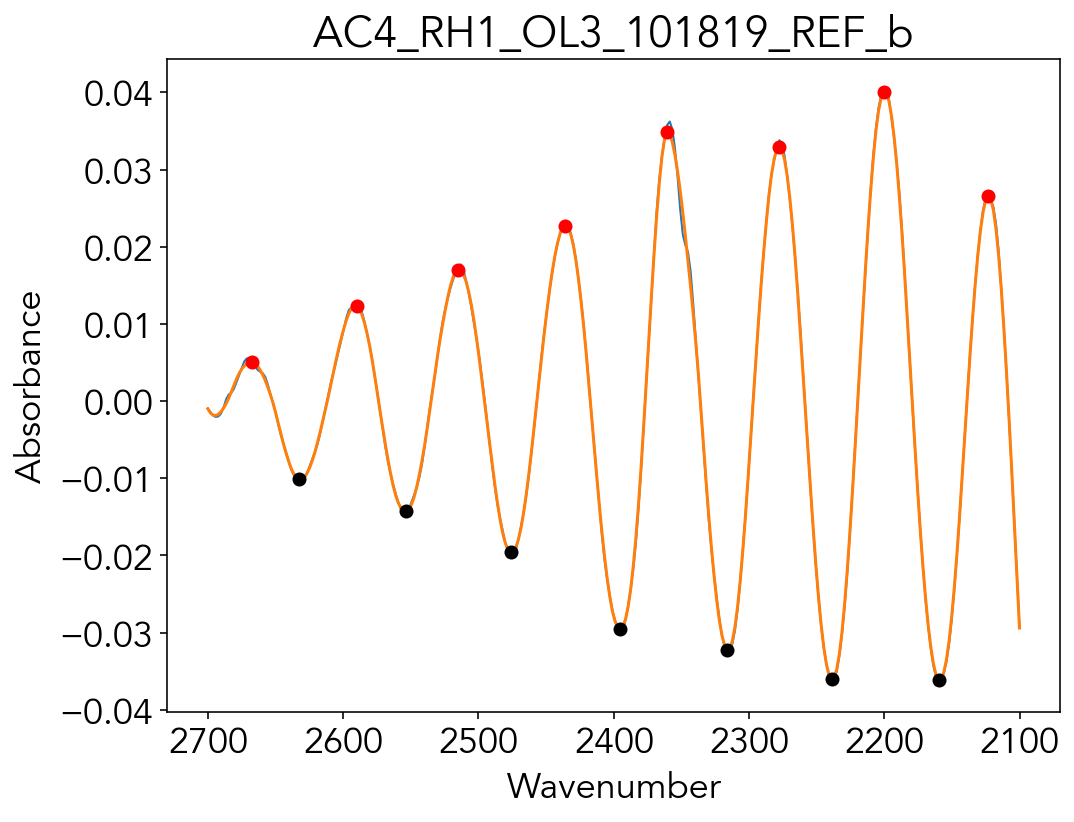

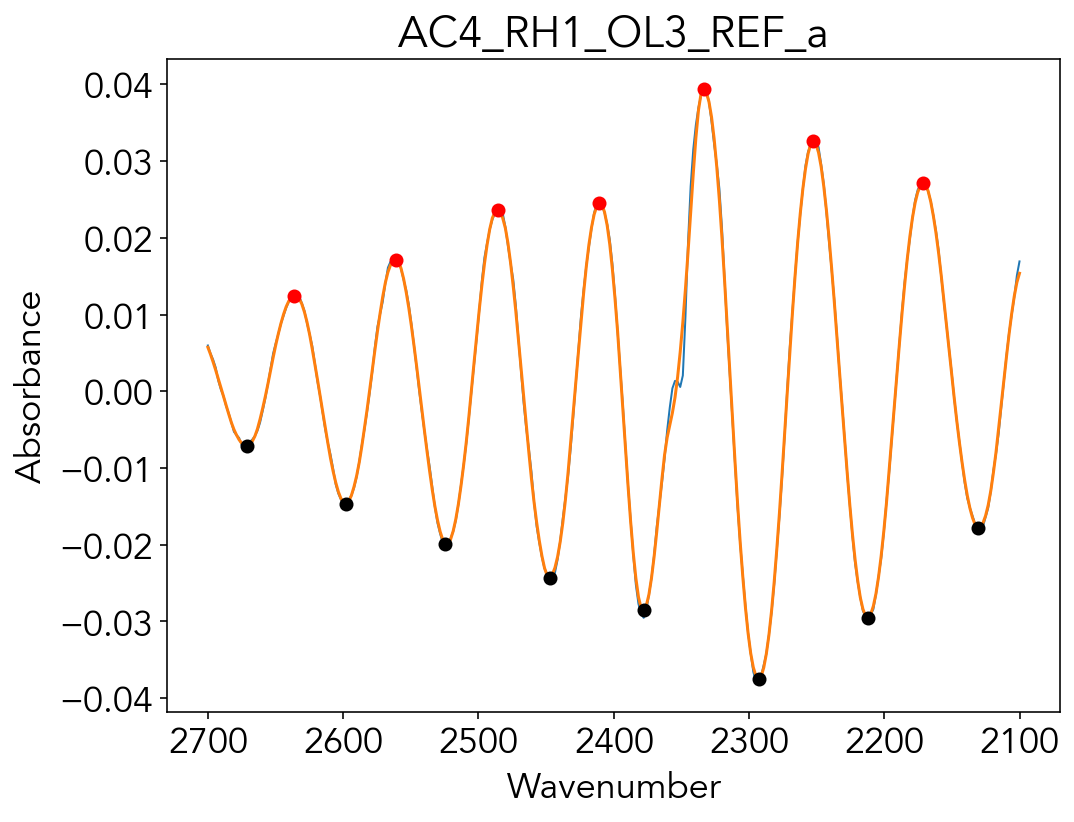

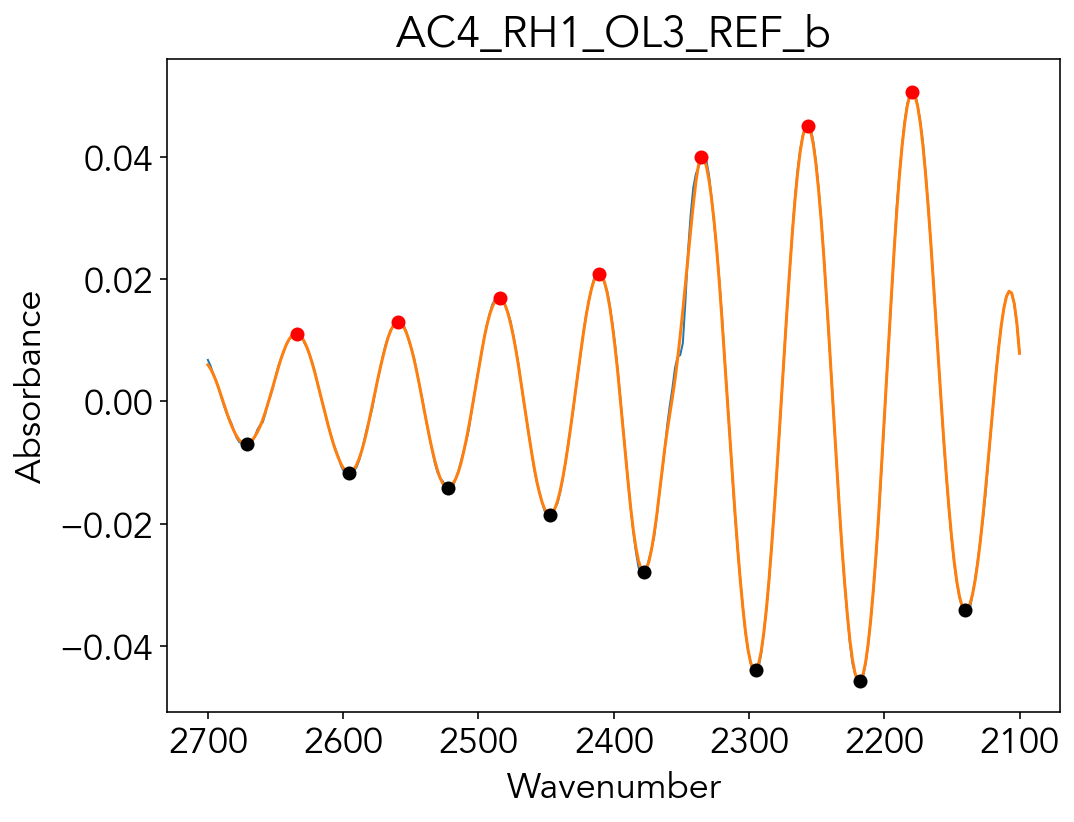

In [3]:
path_parent = os.path.dirname(os.getcwd())
path_input = path_parent + '/Inputs'

# Change paths to direct to folder with SampleSpectra -- last bit should be whatever your folder with spectra is called. 
PATH = path_input + '/ReflectanceSpectra/FuegoOl/'
FILES = glob.glob(PATH + "*")
FILES.sort()

DFS_FILES, DFS_DICT = Load_SampleCSV(FILES, wn_high = 2800, wn_low = 2000)

# n=1.546 in the range of 2000-2700 cm^-1 following Nichols and Wysoczanski, 2007 for basaltic glass
# Provide a wavenumber buffer in these applications. Assess if the range is appropriate by looking at
# the standard deviations associated with each thickness. 

smoothing_wn_width = 15 # lower smoothing 
peak_heigh_min_delta = 0.002
peak_search_width = 10

n_ol = ReflectanceIndex(0.72)

Fuego1 = ThicknessProcessing(DFS_DICT, n = n_ol, wn_high = 2700, wn_low = 2100, savgol_filter_width = 99, smoothing_wn_width = smoothing_wn_width, peak_heigh_min_delta = peak_heigh_min_delta, peak_search_width = 10, remove_baseline = True, plotting = True)

Fuego1.to_csv('FuegoOlThickness.csv')

In [4]:
Fuego1 

Peak_Thicknesses  \
AC4_EUH102_REF_a                               [45.95, 45.95, 45.95, 47.39]   
AC4_EUH102_REF_b                               [47.39, 48.92, 48.91, 43.32]   
AC4_EUH33_REF_a                                [50.55, 52.29, 50.55, 50.54]   
AC4_EUH33_REF_b                  [50.55, 48.91, 52.29, 52.29, 50.54, 50.54]   
AC4_OL21_REF_a            [79.81, 79.81, 79.81, 79.81, 79.81, 79.81, 79....   
AC4_OL21_REF_b            [75.82, 84.24, 79.81, 79.81, 84.24, 84.24, 84....   
AC4_OL24_REF_b            [60.65, 63.18, 65.93, 58.32, 63.18, 60.65, 60....   
AC4_OL27_REF_a            [79.81, 79.81, 79.81, 79.81, 79.81, 79.81, 79....   
AC4_OL27_REF_b            [79.81, 79.81, 79.81, 79.81, 72.21, 75.82, 84....   
AC4_OL40_REF_a            [75.82, 75.82, 72.21, 75.82, 72.21, 79.81, 75....   
AC4_OL40_REF_b            [75.82, 75.82, 72.21, 75.82, 68.93, 68.92, 68.93]   
AC4_OL44_REF_a            [54.16, 58.32, 42.12, 56.16, 54.15, 58.32, 54.16]   
AC4_OL44_REF_b            [54.15, 56.16, 58.32, 50.55, 58.32, 52.29, 54.15]   
AC4_OL45_REF_a                                        [29.16, 29.16, 29.16]   
AC4_OL45_REF_b                                 [29.73, 29.73, 29.73, 29.73]   
AC4_OL47_REF_a            [54.16, 52.29, 52.29, 54.16, 52.29, 52.29, 52.29]   
AC4_OL47_REF_b            [52.29, 52.29, 50.54, 54.16, 50.55, 52.29, 52.29]   
AC4_OL48_REF_a                                  [39.9, 37.91, 37.91, 36.98]   
AC4_OL48_REF_b                                          [39.9, 40.98, 39.9]   
AC4_RH1_OL2_101819_REF_a  [65.93, 68.93, 65.93, 68.93, 65.93, 68.93, 65....   
AC4_RH1_OL2_101819_REF_b                [63.18, 63.18, 63.18, 63.18, 63.18]   
AC4_RH1_OL3_101819_REF_a                       [37.91, 37.91, 37.91, 37.91]   
AC4_RH1_OL3_101819_REF_b                       [37.91, 37.91, 36.98, 37.91]   
AC4_RH1_OL3_REF_a                              [37.91, 38.88, 38.88, 38.88]   
AC4_RH1_OL3_REF_b                              [37.91, 38.88, 38.88, 38.88]   

                          Peak_Thickness_M  Peak_Thickness_STD  \
AC4_EUH102_REF_a                     46.31                0.62   
AC4_EUH102_REF_b                     47.14                2.29   
AC4_EUH33_REF_a                      50.98                0.75   
AC4_EUH33_REF_b                      50.85                1.17   
AC4_OL21_REF_a                       79.81                0.00   
AC4_OL21_REF_b                       81.46                2.76   
AC4_OL24_REF_b                       61.65                2.18   
AC4_OL27_REF_a                       79.81                0.00   
AC4_OL27_REF_b                       77.93                3.63   
AC4_OL40_REF_a                       73.52                5.36   
AC4_OL40_REF_b                       72.35                3.19   
AC4_OL44_REF_a                       53.91                5.12   
AC4_OL44_REF_b                       54.85                2.72   
AC4_OL45_REF_a                       29.16                0.00   
AC4_OL45_REF_b                       29.73                0.00   
AC4_OL47_REF_a                       52.82                0.84   
AC4_OL47_REF_b                       52.06                1.15   
AC4_OL48_REF_a                       38.17                1.07   
AC4_OL48_REF_b                       40.26                0.51   
AC4_RH1_OL2_101819_REF_a             67.13                1.47   
AC4_RH1_OL2_101819_REF_b             63.18                0.00   
AC4_RH1_OL3_101819_REF_a             37.91                0.00   
AC4_RH1_OL3_101819_REF_b             37.68                0.40   
AC4_RH1_OL3_REF_a                    38.64                0.42   
AC4_RH1_OL3_REF_b                    38.64                0.42   

                                                                   Peak_Loc  \
AC4_EUH102_REF_a                        [2281.47, 2341.26, 2404.9, 2468.54]   
AC4_EUH102_REF_b                        [2277.61, 2337.4, 2406.83, 2462.76]   
AC4_EUH33_REF_a                [2283.4, 2339.33, 2

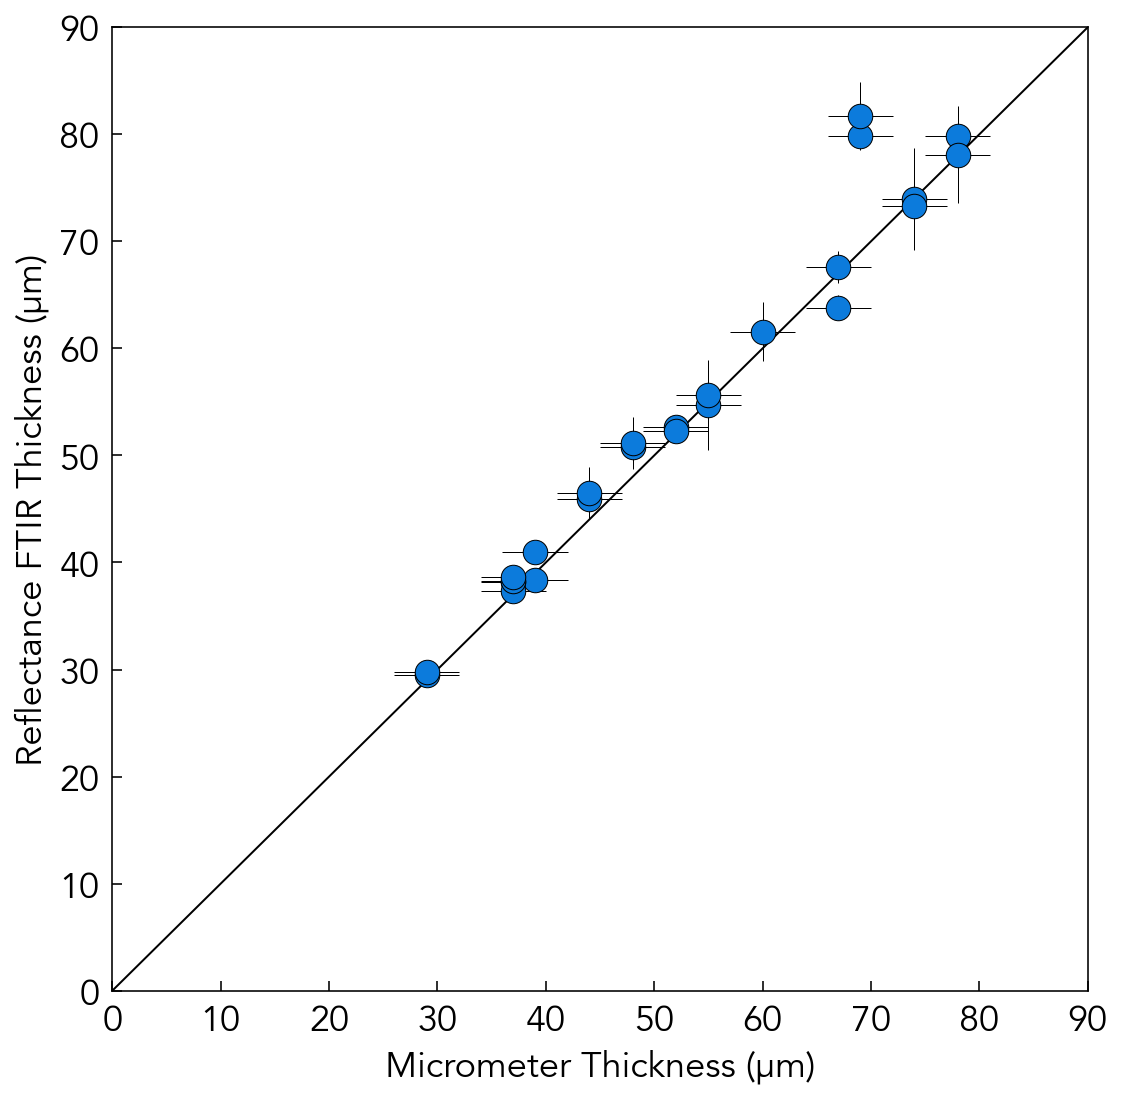

In [5]:
micro = pd.read_csv('FuegoOlMicrometer.csv')

range = [0, 90]

sz = 150
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(range, range, 'k', lw = 1, zorder = 0)

ax.errorbar(micro.Thickness_Micrometer, Fuego1.Thickness_M, yerr = Fuego1.Thickness_STD, xerr = 3, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(micro.Thickness_Micrometer, Fuego1.Thickness_M, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax.set_xlim([0, 90])
ax.set_ylim([0, 90])

ax.set_xlabel('Micrometer Thickness (µm)')
ax.set_ylabel('Reflectance FTIR Thickness (µm)')
ax.tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax.tick_params(axis="y", direction='in', length=5, pad = 6.5)
plt.tight_layout()
plt.savefig('OlThicknessTest.pdf')

In [6]:
path_parent = os.path.dirname(os.getcwd())
path_input = path_parent + '/Inputs'

# Change paths to direct to folder with SampleSpectra -- last bit should be whatever your folder with spectra is called. 
PATH = path_input + '/ReflectanceSpectra/rf_ND70/'
FILES = glob.glob(PATH + "*")
FILES.sort()

DFS_FILES, DFS_DICT = Load_SampleCSV(FILES, wn_high = 2850, wn_low = 1700)

Peak_Thicknesses  \
ND70_02-01_30June2022_150x150_rf_sp1          [37.27, 37.68, 35.87, 38.11, 36.46, 36.26, 37....   
ND70_02-01_30June2022_150x150_rf_sp2          [37.06, 37.47, 38.33, 35.49, 34.76, 33.37, 33....   
ND70_02-01_30June2022_150x150_rf_sp3          [37.9, 38.11, 38.33, 38.55, 39.69, 39.69, 39.2...   
ND70_02-01_30June2022_150x150_rf_sp4            [39.23, 39.23, 39.46, 38.77, 39.0, 39.0, 38.55]   
ND70_03-01_30June2022_150x150_rf_sp4          [37.47, 37.9, 37.68, 36.46, 35.68, 34.94, 34.9...   
ND70_4_2_150x150_29June2022_256s_rf_sp2       [55.9, 54.98, 54.54, 51.21, 54.1, 54.1, 55.9, ...   
ND70_5_2_29June2022_150x150_rf_sp1            [57.33, 54.54, 55.44, 54.1, 54.54, 55.44, 52.4...   
ND70_5_2_29June2022_150x150_rf_sp2            [49.69, 50.06, 51.6, 52.82, 49.32, 51.21, 53.6...   
ND70_6_02_Reflected_75umapt                                  [26.31, 25.12, 23.05, 23.05, 25.6]   
ND70_6_02_Reflected_75umapt_normal_spect_Res                       [27.49, 26.62, 23.45, 24.48]   

                                              Peak_Thickness_M  \
ND70_02-01_30June2022_150x150_rf_sp1                     36.78   
ND70_02-01_30June2022_150x150_rf_sp2                     35.57   
ND70_02-01_30June2022_150x150_rf_sp3                     38.44   
ND70_02-01_30June2022_150x150_rf_sp4                     39.03   
ND70_03-01_30June2022_150x150_rf_sp4                     36.37   
ND70_4_2_150x150_29June2022_256s_rf_sp2                  53.67   
ND70_5_2_29June2022_150x150_rf_sp1                       55.14   
ND70_5_2_29June2022_150x150_rf_sp2                       51.04   
ND70_6_02_Reflected_75umapt                              24.63   
ND70_6_02_Reflected_75umapt_normal_spect_Res             25.51   

                                              Peak_Thickness_STD  \
ND70_02-01_30June2022_150x150_rf_sp1                        0.77   
ND70_02-01_30June2022_150x150_rf_sp2                        1.71   
ND70_02-01_30June2022_150x150_rf_sp3                        0.84   
ND70_02-01_30June2022_150x150_rf_sp4                        0.28   
ND70_03-01_30June2022_150x150_rf_sp4                        1.02   
ND70_4_2_150x150_29June2022_256s_rf_sp2                     1.61   
ND70_5_2_29June2022_150x150_rf_sp1                          1.27   
ND70_5_2_29June2022_150x150_rf_sp2                          1.24   
ND70_6_02_Reflected_75umapt                                 1.34   
ND70_6_02_Reflected_75umapt_normal_spect_Res                1.62   

                                                                                       Peak_Loc  \
ND70_02-01_30June2022_150x150_rf_sp1          [2012.44, 2096.81, 2186.97, 2271.83, 2360.54, ...   
ND70_02-01_30June2022_150x150_rf_sp2          [2033.65, 2124.78, 2249.17, 2342.22, 2423.7, 2...   
ND70_02-01_30June2022_150x150_rf_sp3          [1995.56, 2079.46, 2160.94, 2260.26, 2341.74, ...   
ND70_02-01_30June2022_150x150_rf_sp4          [2019.67, 2102.12, 2184.08, 2267.49, 2348.49, ...   
ND70_03-01_30June2022_150x150_rf_sp4          [1964.71, 2050.53, 2139.24, 2229.88, 2322.45, ...   
ND70_4_2_150x150_29June2022_256s_rf_sp2       [1971.94, 2035.1, 2094.89, 2154.67, 2212.53, 2...   
ND70_5_2_29June2022_150x150_rf_sp1            [1987.85, 2047.64, 2100.19, 2159.49, 2217.83, ...   
ND70_5_2_29June2022_150x150_rf_sp2            [2000.87, 2070.3, 2138.76, 2201.44, 2262.67, 2...   
ND70_6_02_Reflected_75umapt                       [1985.92, 2101.15, 2241.46, 2356.69, 2496.99]   
ND70_6_02_Reflected_75umapt_normal_spect_Res      [1988.33, 2126.22, 2241.94, 2357.65, 2503.26]   

                                                                                      Peak_Diff  \
ND70_02-01_30June2022_150x150_rf_sp1          [86.78, 85.82, 90.16, 84.86, 88.71, 89.2, 86.7...   
ND70_02-01_30June2022_150x150_rf_sp2          [87.27, 86.3, 84.37, 91.12, 93.05, 96.91, 95.4...   
ND70_02-01_30June2022_150x150_rf_sp3          [85.34, 84.86, 84.37, 83.89, 81.48, 81.48, 82....   
ND70_02-01_30June2022_150x1

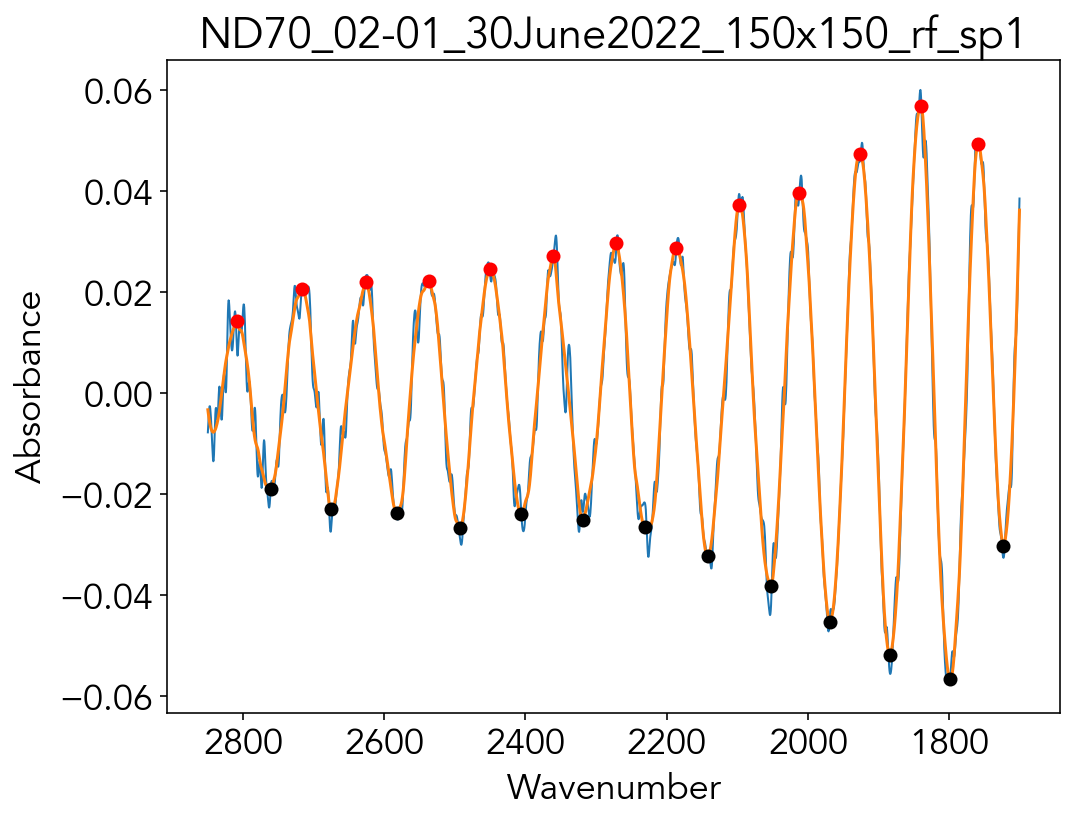

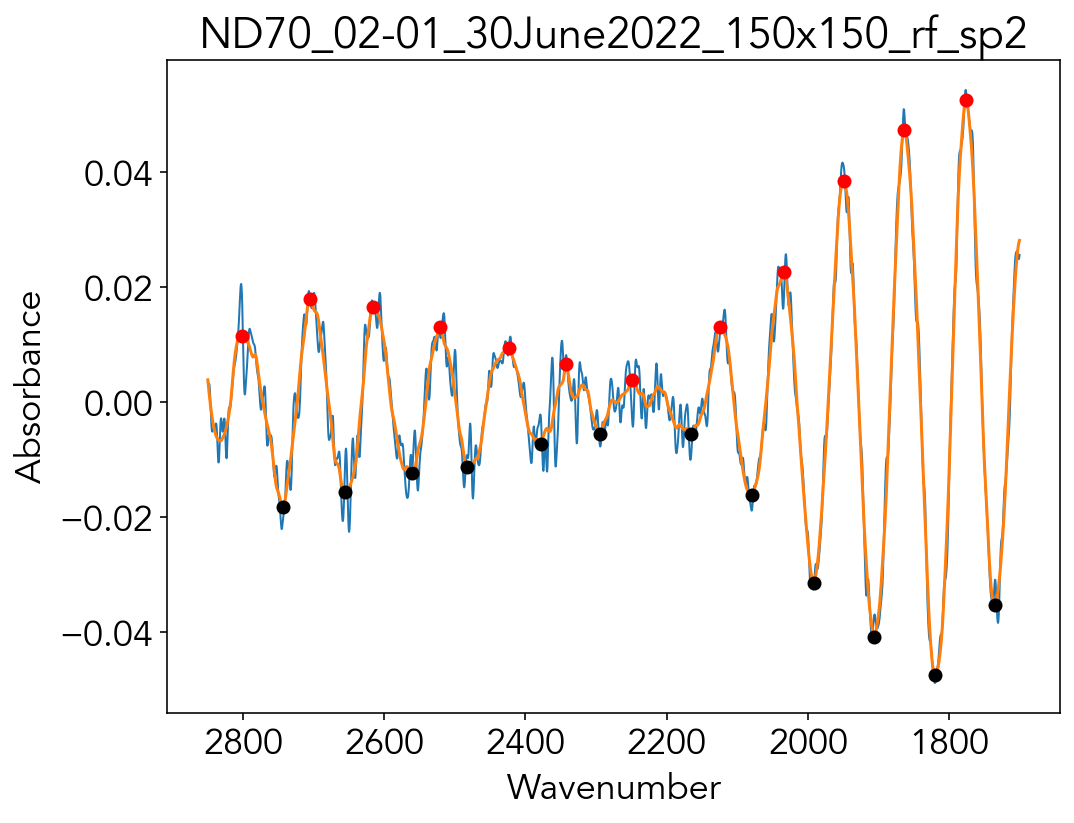

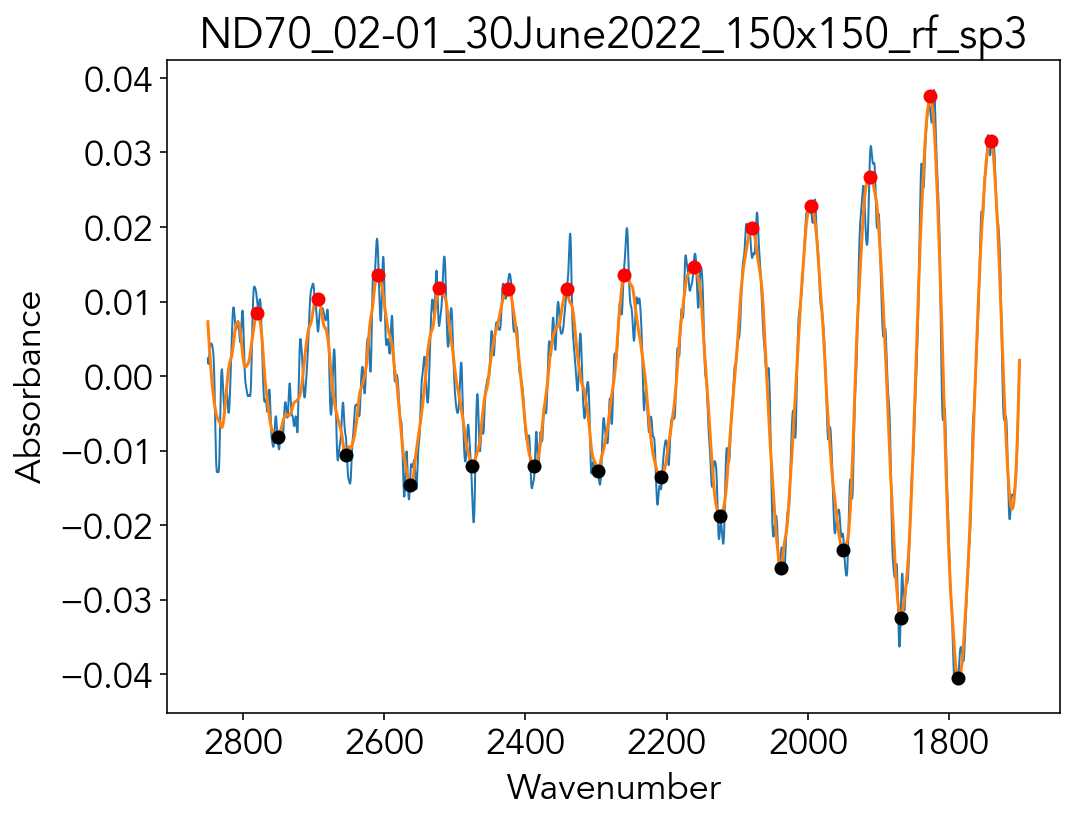

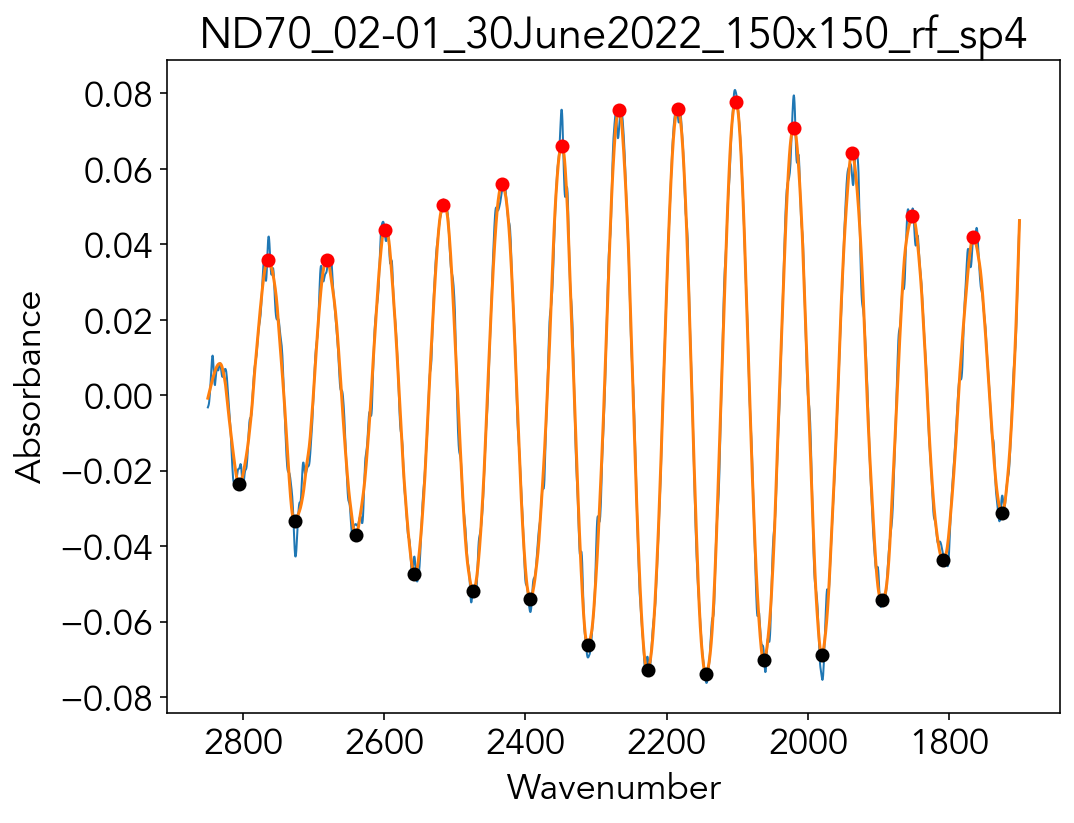

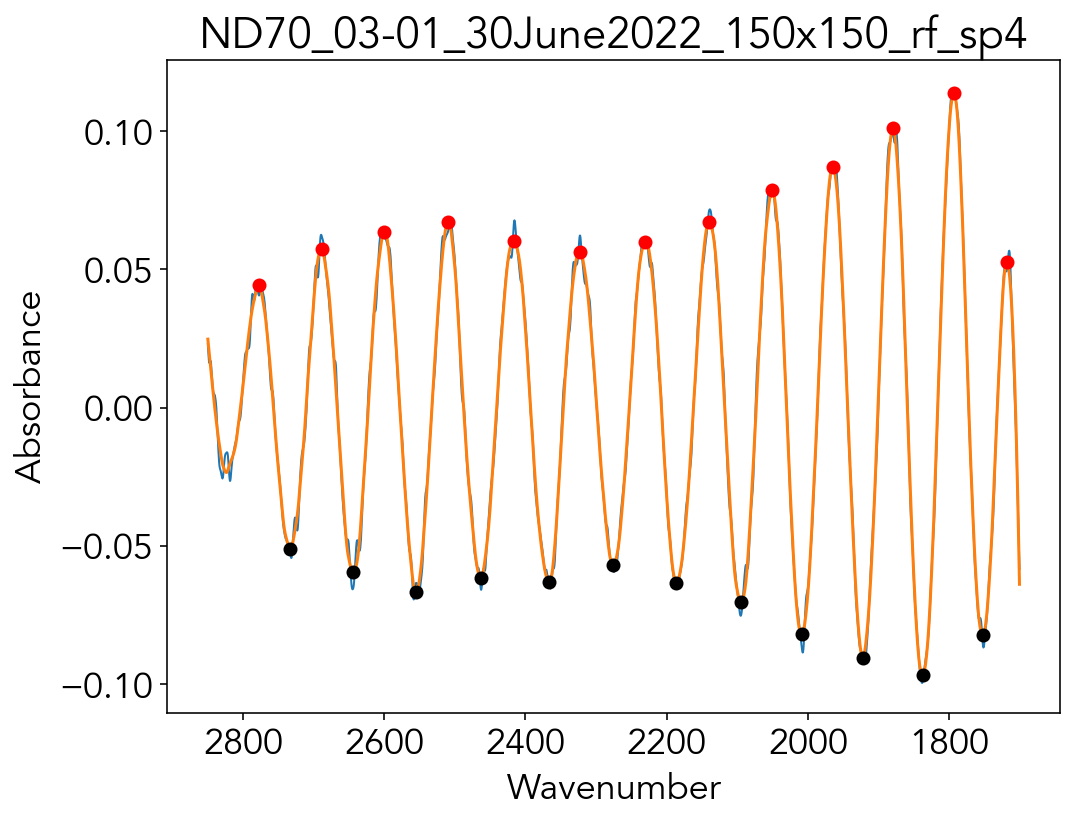

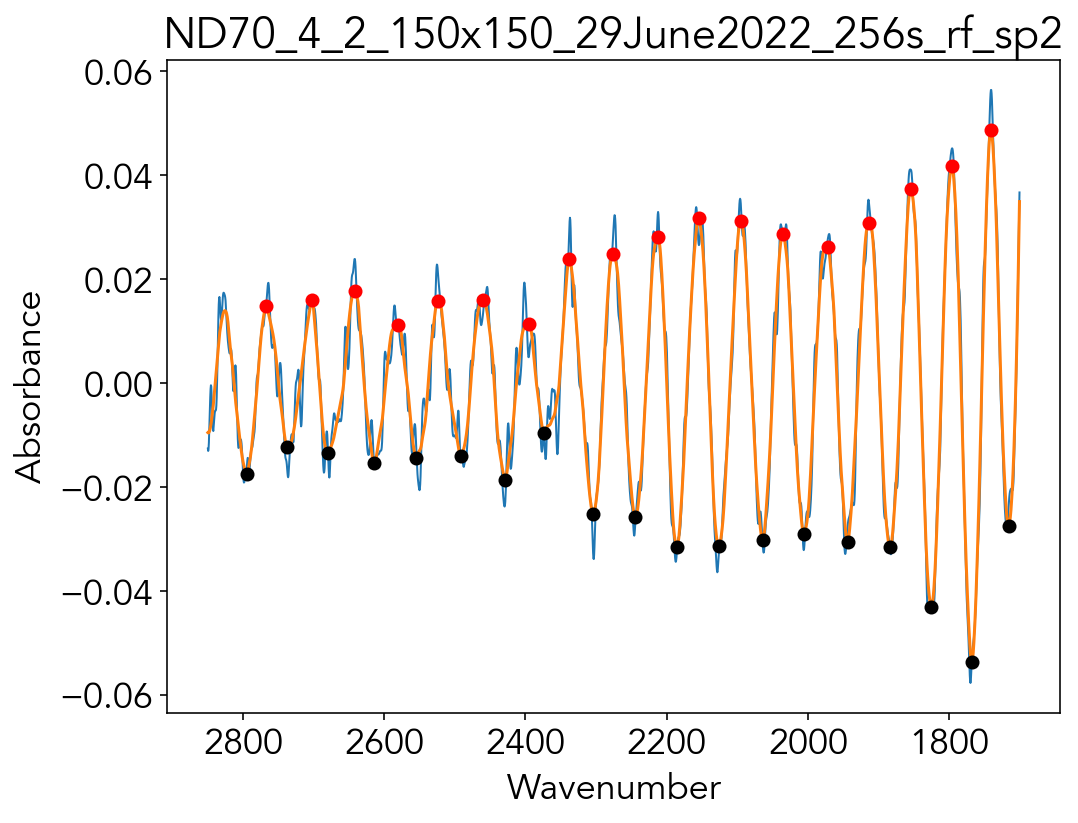

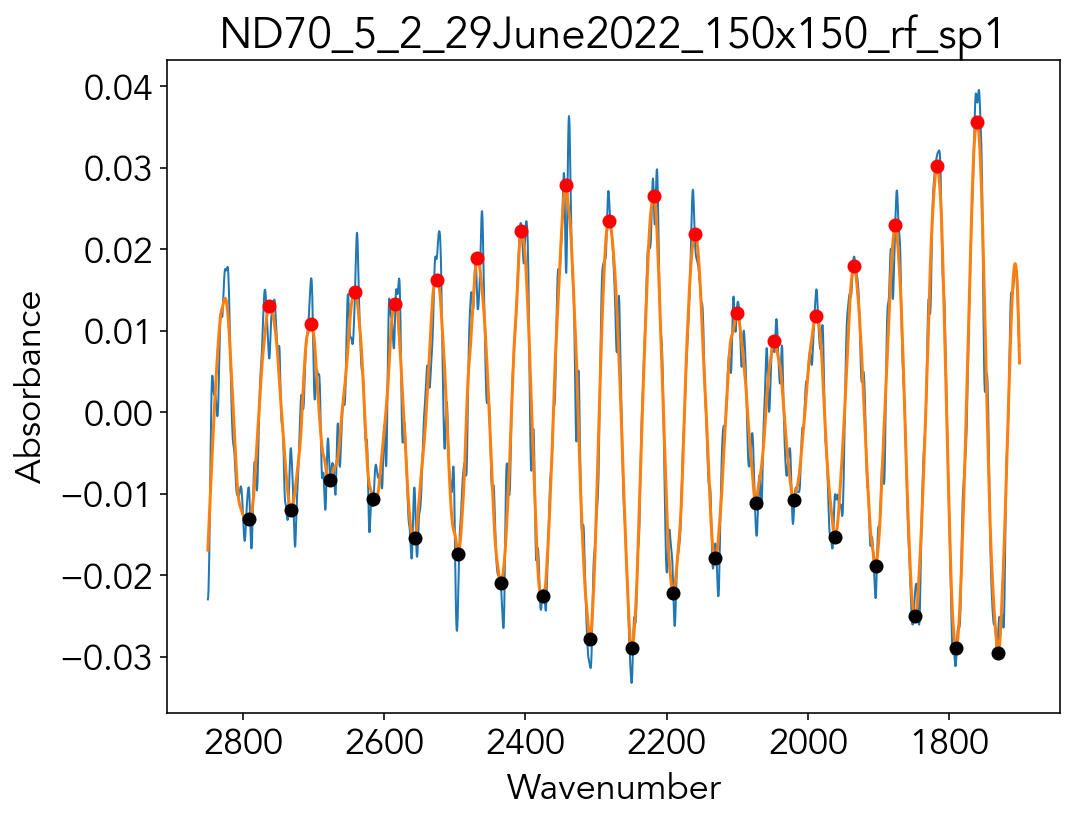

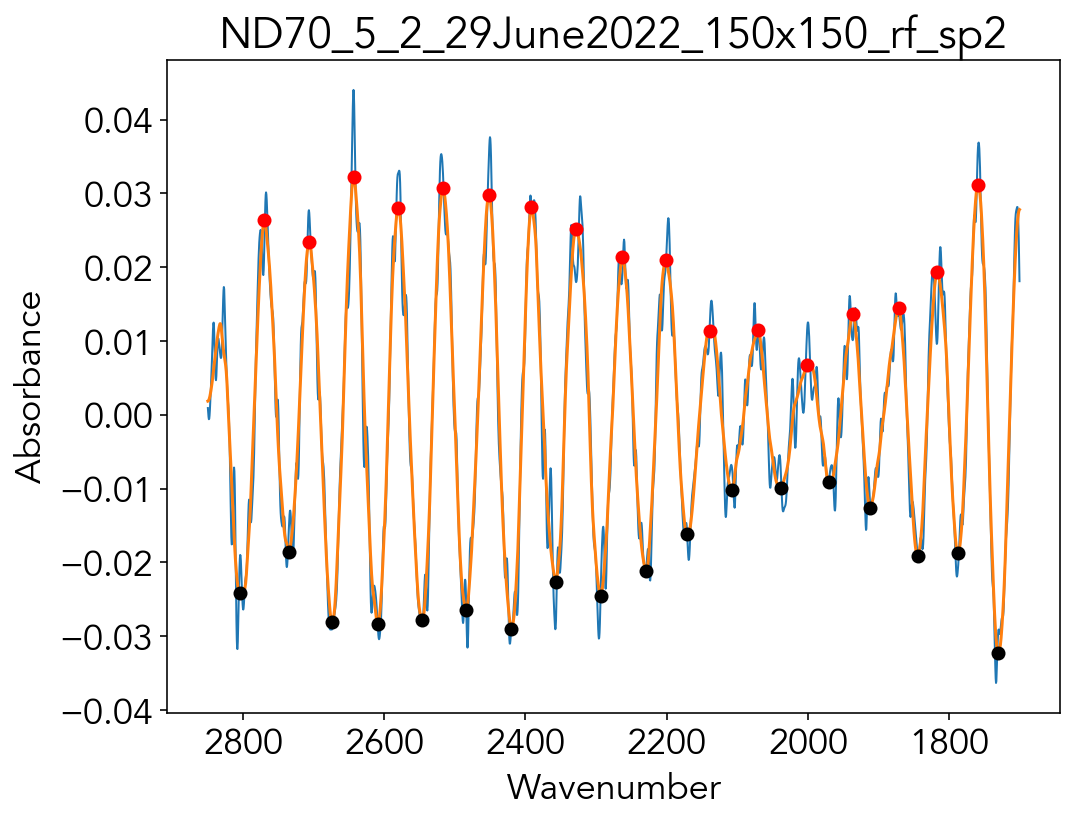

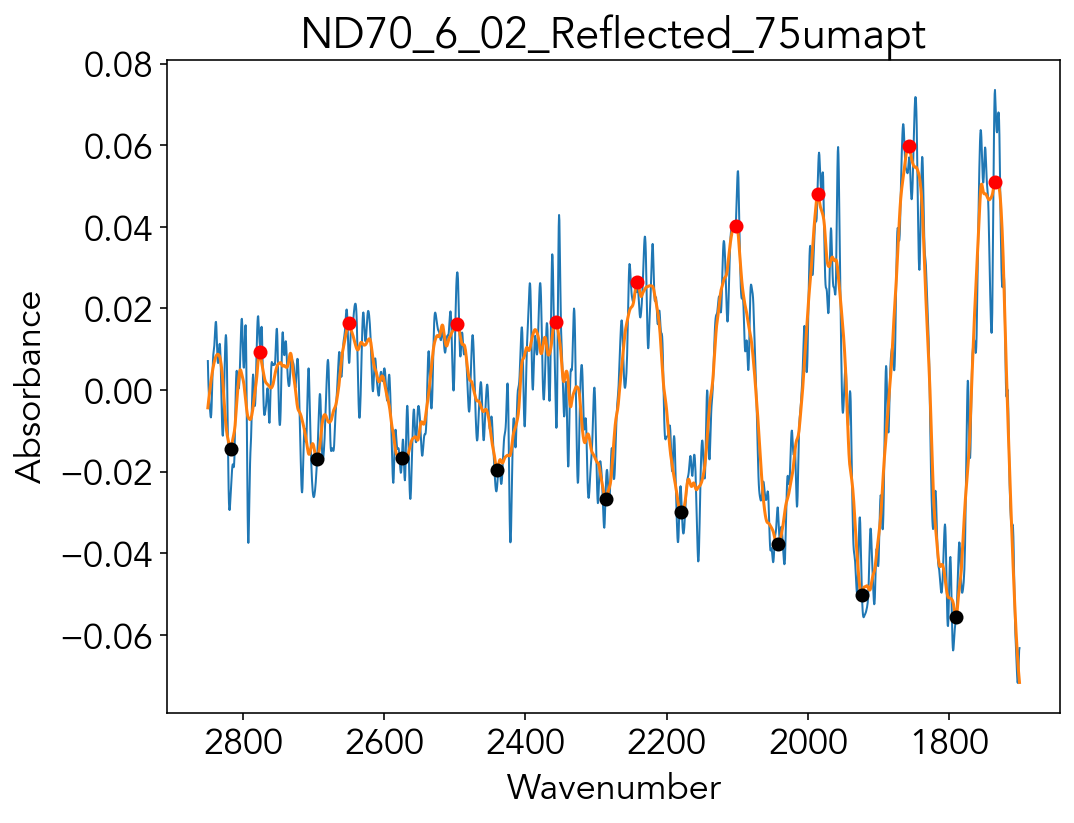

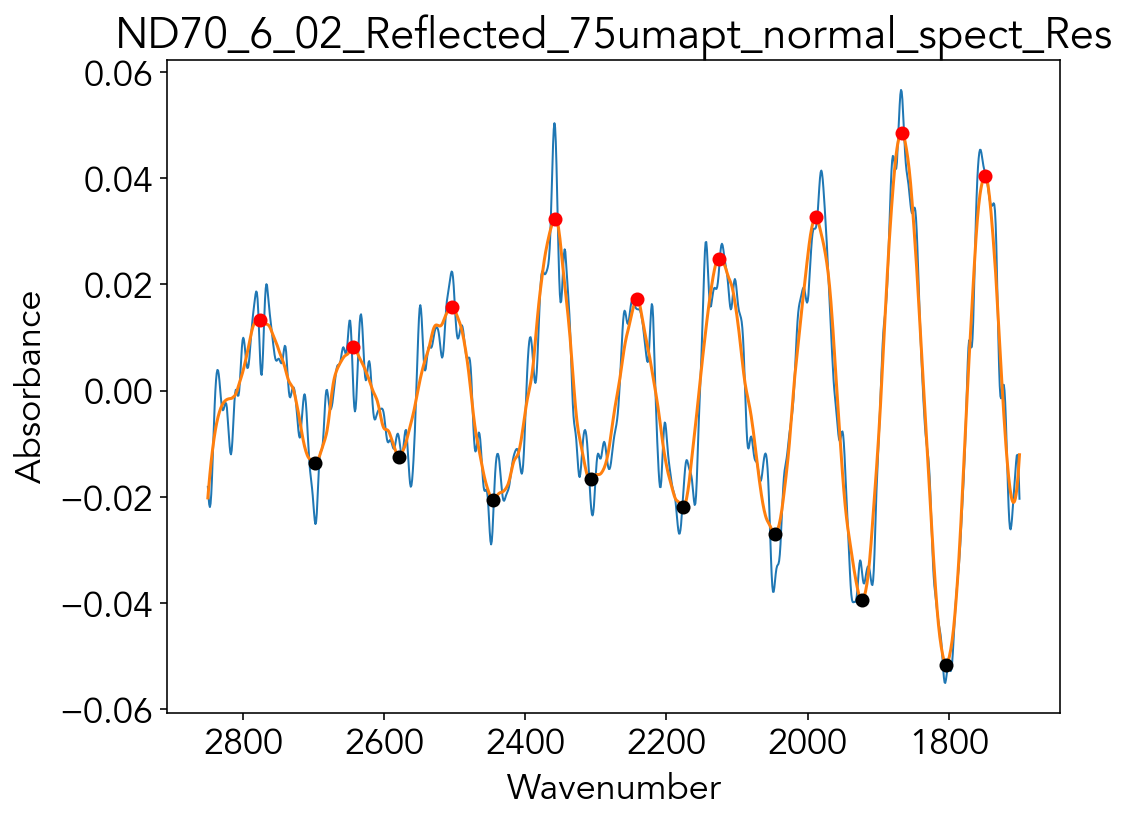

In [7]:
# n=1.546 in the range of 2000-2700 cm^-1 following Nichols and Wysoczanski, 2007 for basaltic glass
# Provide a wavenumber buffer in these applications. Assess if the range is appropriate by looking at
# the standard deviations associated with each thickness. 

smoothing_wn_width = 71
peak_heigh_min_delta = 0.008
peak_search_width = 50

HighThickDF = ThicknessProcessing(DFS_DICT, n = 1.546, wn_high = 2850, wn_low = 1700, savgol_filter_width = 449, smoothing_wn_width = smoothing_wn_width, peak_heigh_min_delta= peak_heigh_min_delta, peak_search_width = peak_search_width, remove_baseline = True, plotting = True)

HighThickDF

In [8]:
HighThickDF.to_csv('ND70_Thickness_HighQuality.csv')

In [9]:
path_parent = os.path.dirname(os.getcwd())
path_input = path_parent + '/Inputs'

# Change paths to direct to folder with SampleSpectra -- last bit should be whatever your folder with spectra is called. 
PATH = path_input + '/ReflectanceSpectra/rf_ND70/'
FILES = glob.glob(PATH + "*")
FILES.sort()

DFS_FILES, DFS_DICT = Load_SampleCSV(FILES, wn_high = 2850, wn_low = 1700)

/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sarahc

Error: If mode is 'interp', window_length must be less than or equal to the size of x.
If mode is 'interp', window_length must be less than or equal to the size of x.


/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/sarahcshi/opt/anaconda3/envs/General_Science/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Peak_Thicknesses  \
ND70_02-01_30June2022_150x150_rf_sp1                      [36.66]   
ND70_02-01_30June2022_150x150_rf_sp2                           []   
ND70_02-01_30June2022_150x150_rf_sp3                [37.9, 39.69]   
ND70_02-01_30June2022_150x150_rf_sp4                [39.0, 38.77]   
ND70_03-01_30June2022_150x150_rf_sp4               [36.06, 35.12]   
ND70_4_2_150x150_29June2022_256s_rf_sp2             [54.54, 54.1]   
ND70_5_2_29June2022_150x150_rf_sp1                 [54.54, 55.44]   
ND70_5_2_29June2022_150x150_rf_sp2            [47.24, 52.0, 52.0]   
ND70_6_02_Reflected_75umapt                               [22.97]   
ND70_6_02_Reflected_75umapt_normal_spect_Res                  NaN   

                                              Peak_Thickness_M  \
ND70_02-01_30June2022_150x150_rf_sp1                     36.66   
ND70_02-01_30June2022_150x150_rf_sp2                       NaN   
ND70_02-01_30June2022_150x150_rf_sp3                     38.80   
ND70_02-01_30June2022_150x150_rf_sp4                     38.89   
ND70_03-01_30June2022_150x150_rf_sp4                     35.59   
ND70_4_2_150x150_29June2022_256s_rf_sp2                  54.32   
ND70_5_2_29June2022_150x150_rf_sp1                       54.99   
ND70_5_2_29June2022_150x150_rf_sp2                       50.41   
ND70_6_02_Reflected_75umapt                              22.97   
ND70_6_02_Reflected_75umapt_normal_spect_Res               NaN   

                                              Peak_Thickness_STD  \
ND70_02-01_30June2022_150x150_rf_sp1                        0.00   
ND70_02-01_30June2022_150x150_rf_sp2                         NaN   
ND70_02-01_30June2022_150x150_rf_sp3                        0.89   
ND70_02-01_30June2022_150x150_rf_sp4                        0.11   
ND70_03-01_30June2022_150x150_rf_sp4                        0.47   
ND70_4_2_150x150_29June2022_256s_rf_sp2                     0.22   
ND70_5_2_29June2022_150x150_rf_sp1                          0.45   
ND70_5_2_29June2022_150x150_rf_sp2                          2.24   
ND70_6_02_Reflected_75umapt                                 0.00   
ND70_6_02_Reflected_75umapt_normal_spect_Res                 NaN   

                                                                 Peak_Loc  \
ND70_02-01_30June2022_150x150_rf_sp1                            [2096.81]   
ND70_02-01_30June2022_150x150_rf_sp2                                   []   
ND70_02-01_30June2022_150x150_rf_sp3                   [2079.46, 2160.94]   
ND70_02-01_30June2022_150x150_rf_sp4                    [2102.12, 2183.6]   
ND70_03-01_30June2022_150x150_rf_sp4                   [2049.56, 2139.24]   
ND70_4_2_150x150_29June2022_256s_rf_sp2       [2035.58, 2094.89, 2154.67]   
ND70_5_2_29June2022_150x150_rf_sp1            [2048.12, 2100.19, 2159.49]   
ND70_5_2_29June2022_150x150_rf_sp2             [2070.3, 2138.76, 2200.96]   
ND70_6_02_Reflected_75umapt                                     [2101.15]   
ND70_6_02_Reflected_75umapt_normal_spect_Res                          NaN   

                                                   Peak_Diff  \
ND70_02-01_30June2022_150x150_rf_sp1                 [88.23]   
ND70_02-01_30June2022_150x150_rf_sp2                      []   
ND70_02-01_30June2022_150x150_rf_sp3          [85.34, 81.48]   
ND70_02-01_30June2022_150x150_rf_sp4          [82.93, 83.41]   
ND70_03-01_30June2022_150x150_rf_sp4          [89.68, 92.09]   
ND70_4_2_150x150_29June2022_256s_rf_sp2        [59.3, 59.78]   
ND70_5_2_29June2022_150x150_rf_sp1             [59.3, 58.34]   
ND70_5_2_29June2022_150x150_rf_sp2             [68.46, 62.2]   
ND70_6_02_Reflected_75umapt                         [140.78]   
ND70_6_02_Reflected_75umapt_normal_spect_Res             NaN   

                                                 Trough_Thicknesses  \
ND70_02-01_30June2022_150x150_rf_sp1                 [36.06, 35.87]   
ND70_02-01_30June2022_150x150_rf_sp2                        [37.69]   
ND70_02-01_30June2022_150x150_rf_sp3           

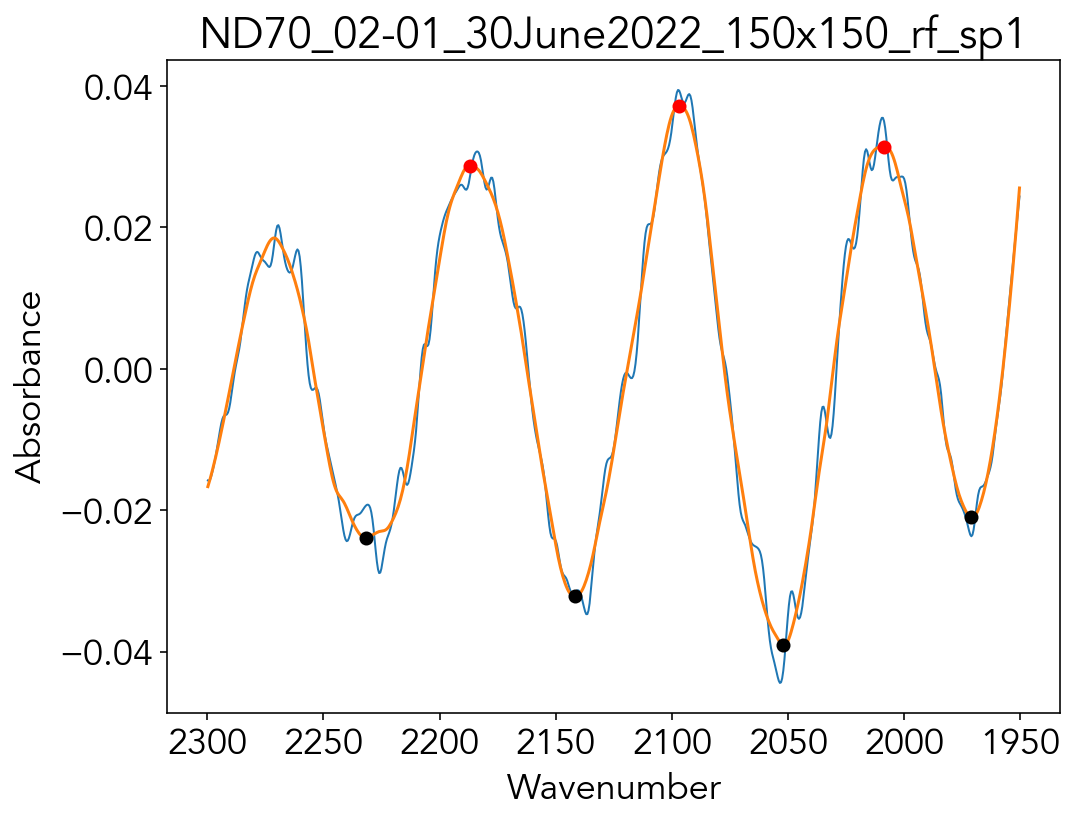

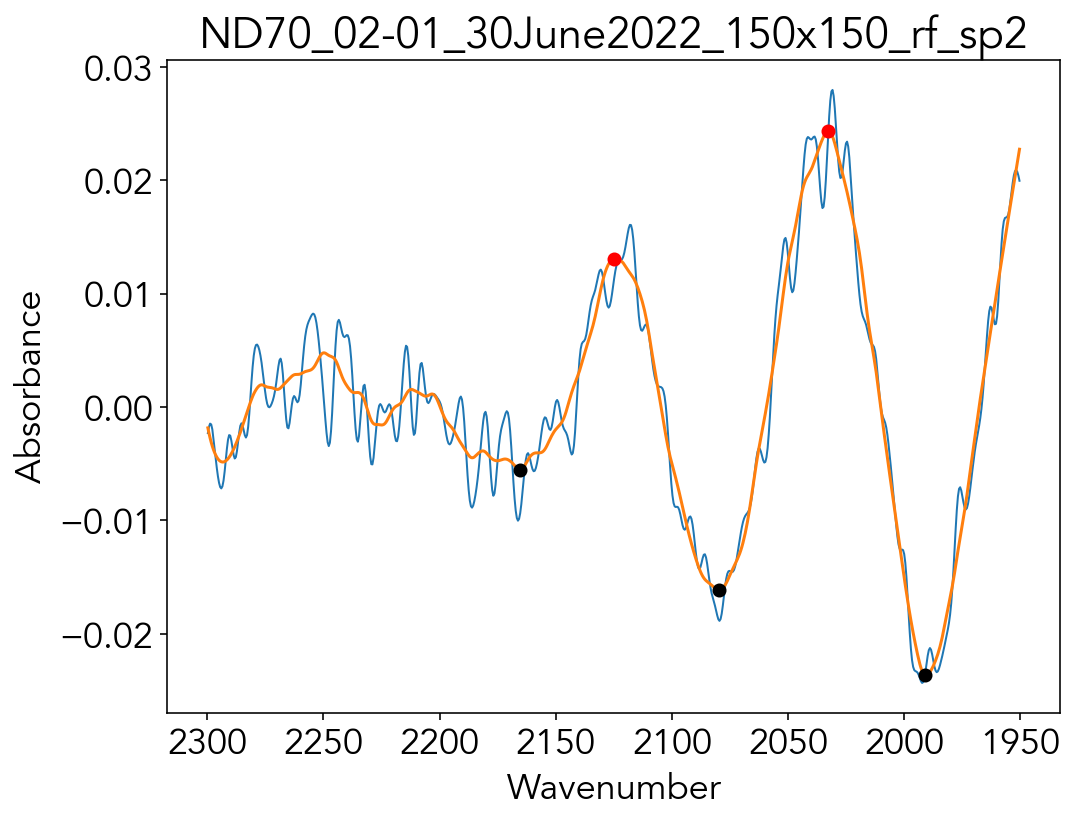

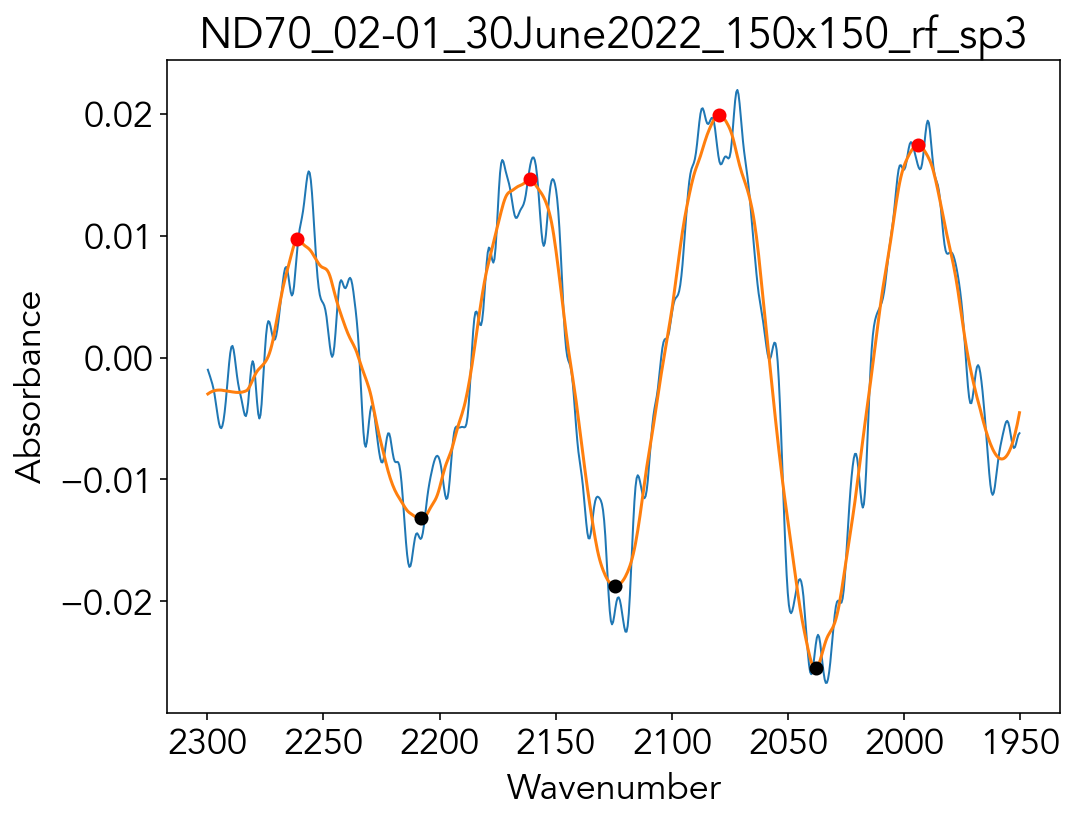

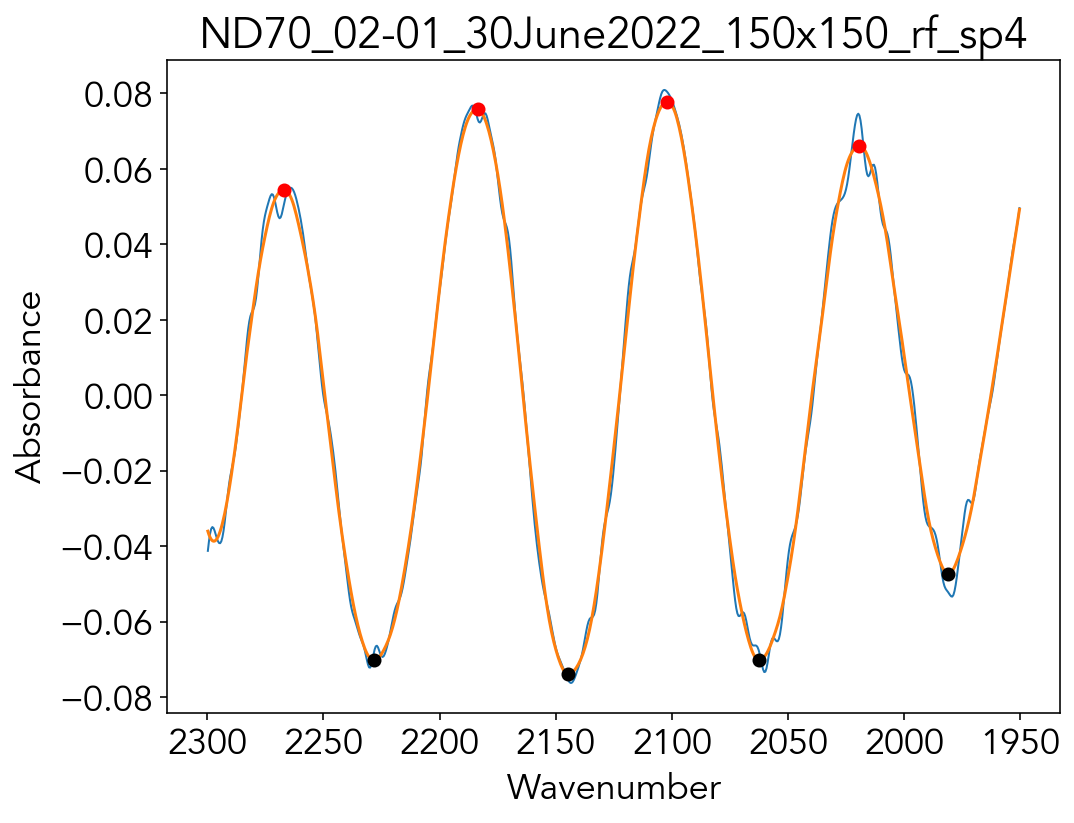

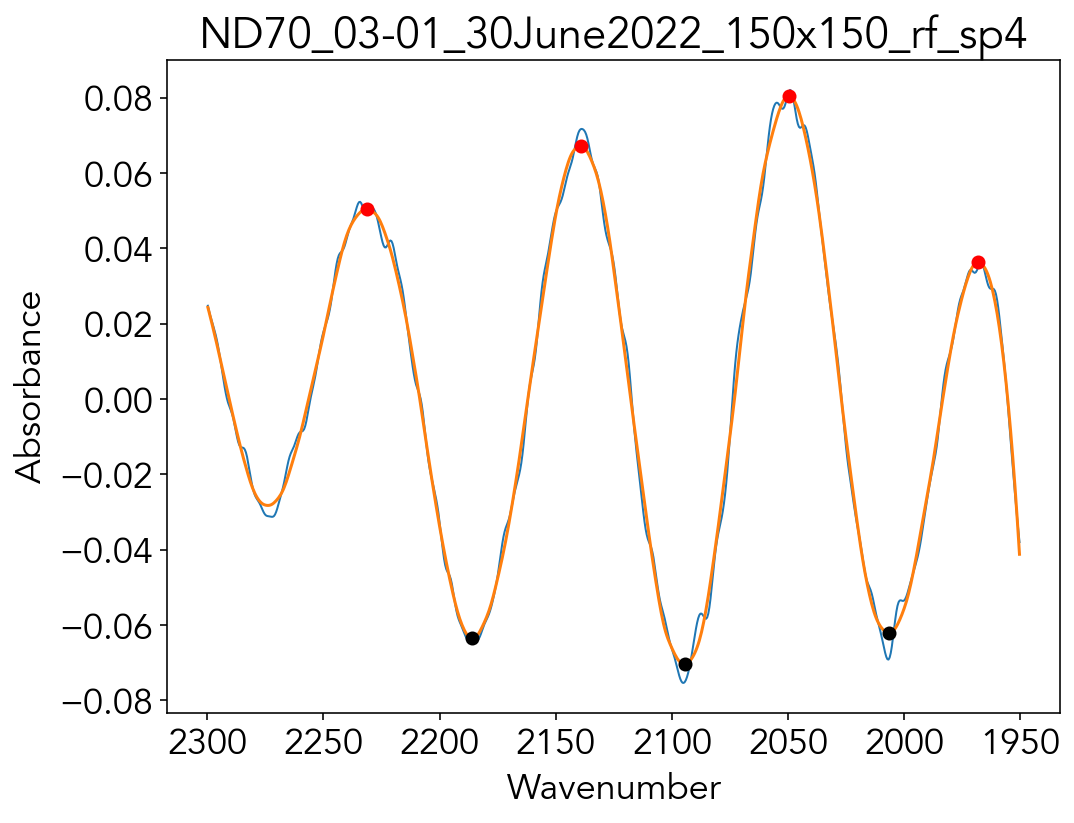

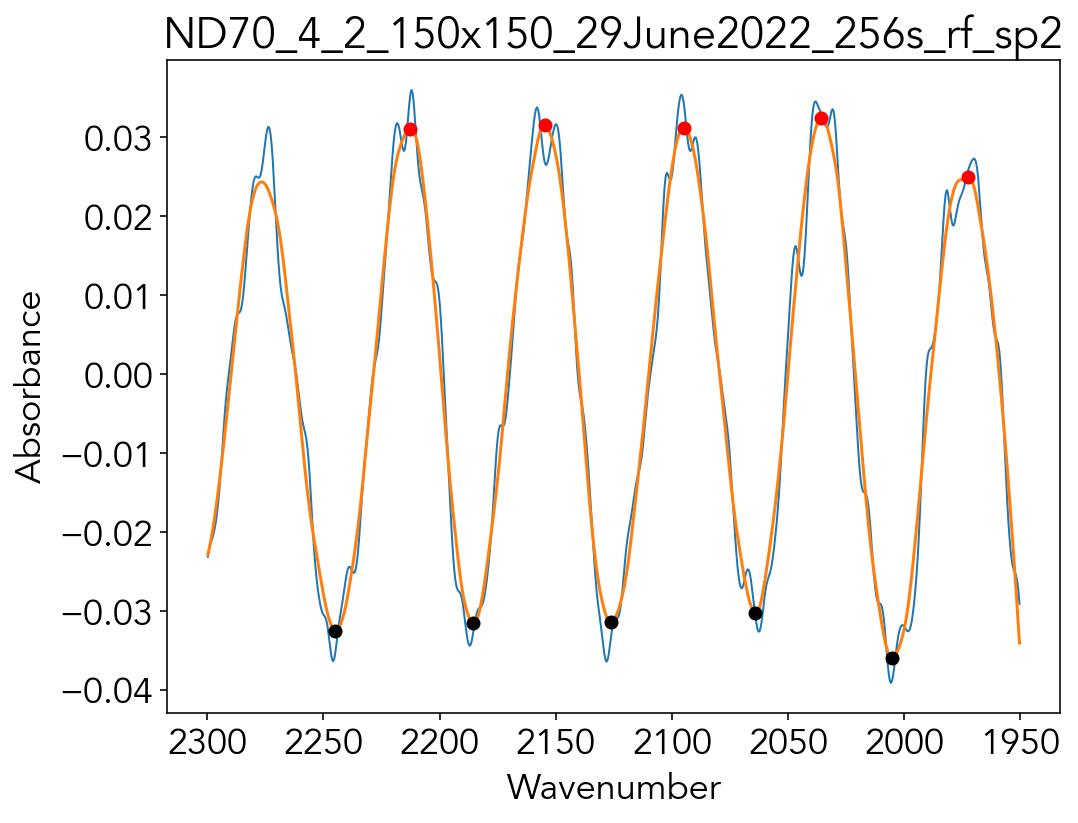

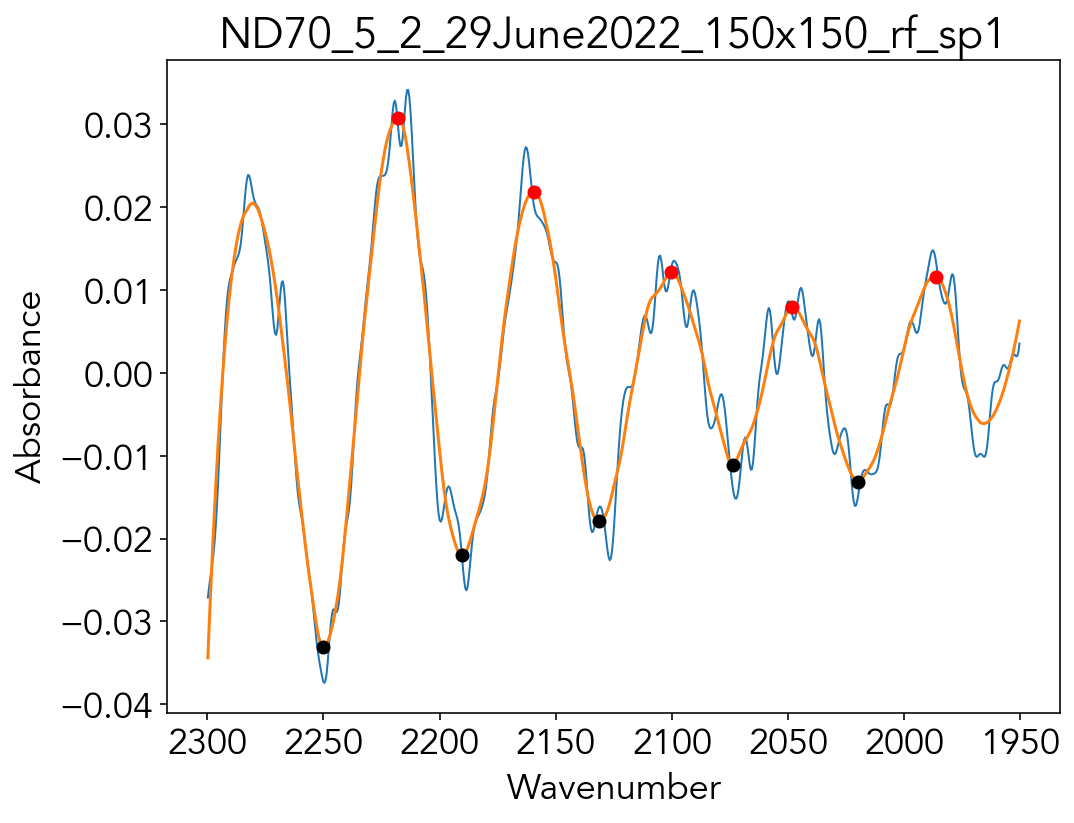

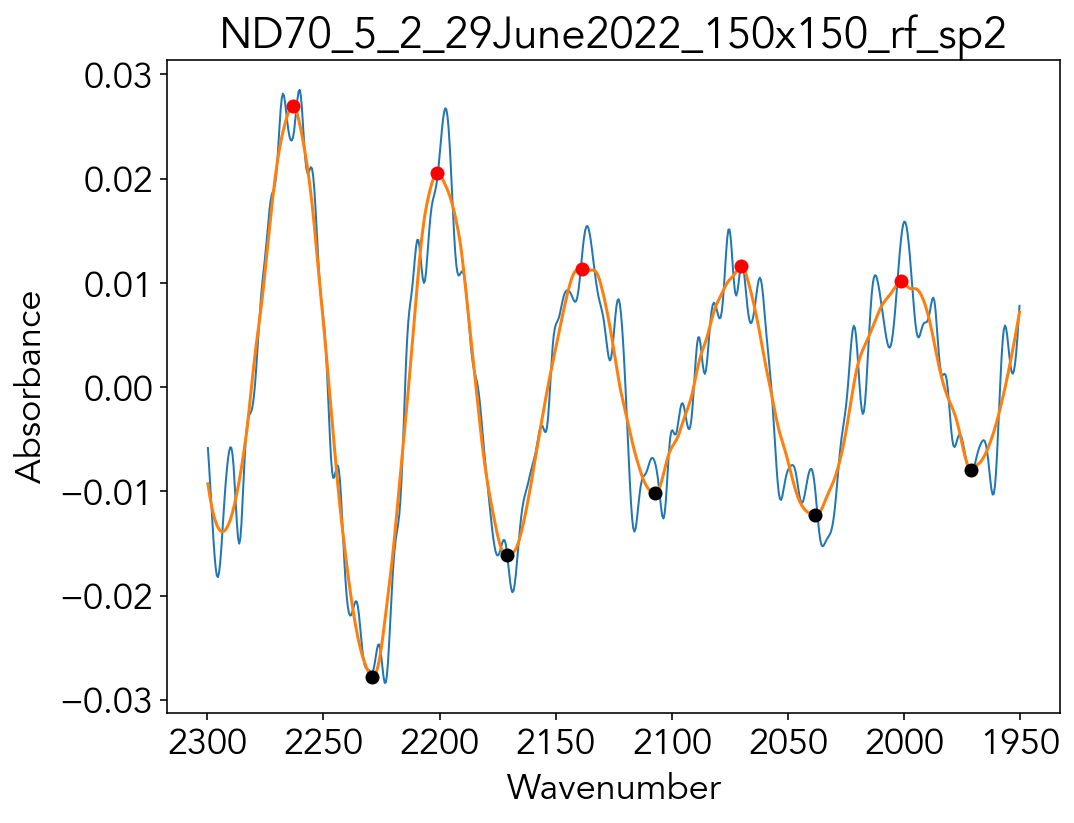

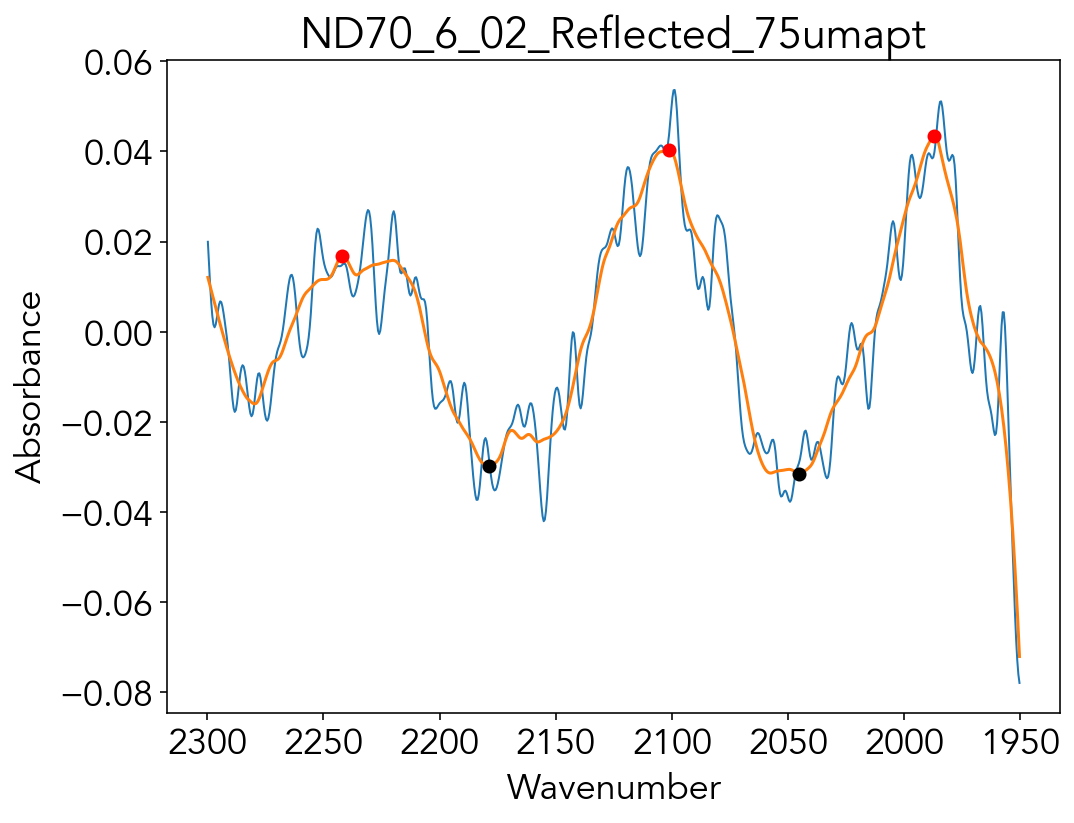

In [10]:
# n=1.546 in the range of 2000-2700 cm^-1 following Nichols and Wysoczanski, 2007 for basaltic glass
# Provide a wavenumber buffer in these applications. Assess if the range is appropriate by looking at
# the standard deviations associated with each thickness. 

smoothing_wn_width = 71
peak_heigh_min_delta = 0.008
peak_search_width = 50

LowThickDF = ThicknessProcessing(DFS_DICT, n = 1.546, wn_high = 2300, wn_low = 1950, savgol_filter_width = 449, smoothing_wn_width = smoothing_wn_width, peak_heigh_min_delta= peak_heigh_min_delta, peak_search_width = peak_search_width, remove_baseline = True, plotting = True)

LowThickDF

In [11]:
LowThickDF.to_csv('ND70_Thickness_LowQuality.csv')

In [12]:
# n=XFo dependent in the range of 2100-2700 cm^-1 following Nichols and Wysoczanski, 2007 for basaltic glass

n = ReflectanceIndex(0.72)
n

# Thickness otherwise calculated in the same manner, with a slightly narrower range. 
# Provide a 100 cm^-1 buffer in these applications. 

1.7097733333333334